# Alternating Direction Method of Multipliers (ADMM)

ADMM is used to solve constrained optimization problems using a variant of the augmented Lagragian. The scheme uses partial updates for dual variables. The method solves problems of the form:

$$
\argmin_x f(x) + g(x)
$$

Which is equivalent to the contrained problem

$$
\argmin_x f(x) + g(z), \ s.t \ x=z
$$

The optimization is then setup to take a step in the **x** space and then takes a step in the auxhilary space **z**. Thirdly, the accumulated error is captured in the Lagragian variable shared by both steps. (more on this later)

ADMM solves the constrained optimization problem using a Lagrangian:

$$
\mathcal{L}(\mathbf{x}, \mathbf{z}, \mathbf{y}) = f(\mathbf{x}) + g(\mathbf{z}) + \mathbf{y}^T(\mathbf{x} - \mathbf{z}) + \frac{1}{2\lambda} \| \mathbf{x} - \mathbf{z} \|_2^2
$$

which is solved in three steps,

# Proximal Operators

```

"... proximal algorithms, for solving convex optimization problems. Much like Newton’s method is a standard tool for solving unconstrained smooth minimization problems of modest size, proximal algorithms can be viewed as an analogous tool for nonsmooth, constrained, large-scale, or distributed versions of these problems"

```

(Parikh, 2014)

The definition of a proximal operator is:

Let $f: \mathbb{R}^{n} \to \mathbb{R} \in \{+ \infty\}$ be a closed convex function and its `epigraph` is a non empty set. (an epigraph of a function is a set representing all the points on or above the graph of a function.) We then have an effective domain of $\mathcal{f}$ that is a set of points for which $\mathcal{f}$ takes on finite values. The proximal operator $\mathrm{prox}_{f}: \mathbb{R}^{n} \to \mathbb{R}^n$ of $\mathcal{f}$ is defined by

$$
\mathrm{prox}_{\lambda f}(z) = \arg\min_y \left( f(x) + \frac{1}{2\lambda} \| x - z \|^2 \right)
$$

Looks familiar right? Proximal operators can simplfy our steps in ADMM. For example lets look at how an L1 norm's proximal operator becomes a simple thresholding function evaluation.

The L1 norm is defined as:
$$
\|x\|_1 = \sum_{i=1}^n |x_i|
$$

The proximal operator for a function $f(x)$ is defined as:
$$
\text{prox}_{\lambda f}(v) = \arg \min_{x} \left( \frac{1}{2} \|x - v\|_2^2 + \lambda f(x) \right)
$$

For the L1 norm, we have $f(x) = \|x\|_1$, and the proximal operator becomes:
$$
\text{prox}_{\lambda \| \cdot \|_1}(v) = \arg \min_{x} \left( \frac{1}{2} \|x - v\|_2^2 + \lambda \|x\|_1 \right)
$$

Let's break this down step-by-step:

1. **Objective Function**:

   The objective function we want to minimize is:
   $$
   \frac{1}{2} \|x - v\|_2^2 + \lambda \|x\|_1 = \frac{1}{2} \sum_{i=1}^n (x_i - v_i)^2 + \lambda \sum_{i=1}^n |x_i|
   $$

2. **Decompose by Components**:

   Notice that the objective function can be decomposed into a sum of independent terms for each component $x_i$:
   $$
   \sum_{i=1}^n \left( \frac{1}{2} (x_i - v_i)^2 + \lambda |x_i| \right)
   $$
   Hence, we can minimize each term separately for each $x_i$:
   $$
   \min_{x_i} \left( \frac{1}{2} (x_i - v_i)^2 + \lambda |x_i| \right)
   $$

3. **Case Analysis**:

   To solve this minimization problem, we need to consider the subdifferential of the L1 norm. The subdifferential of $|x_i|$ is:
   $$
   \partial |x_i| =
   \begin{cases} 
   \{-1\} & \text{if } x_i < 0 \\
   [-1, 1] & \text{if } x_i = 0 \\
   \{1\} & \text{if } x_i > 0 
   \end{cases}
   $$

4. **First-Order Optimality Condition**:

   For optimality, the derivative (or subgradient) of the objective function should be zero:
   $$
   x_i - v_i + \lambda \partial |x_i| = 0
   $$

   We analyze this for different cases of $x_i$:

   - **Case 1: $x_i > 0$**:
     $$
     x_i - v_i + \lambda = 0 \implies x_i = v_i - \lambda
     $$
     Since $x_i > 0$, we need $v_i > \lambda$.

   - **Case 2: $x_i < 0$**:
     $$
     x_i - v_i - \lambda = 0 \implies x_i = v_i + \lambda
     $$
     Since $x_i < 0$, we need $v_i < -\lambda$.

   - **Case 3: $x_i = 0$**:
     $$
     -\lambda \leq v_i \leq \lambda
     $$
     Here, $x_i$ remains 0 if $v_i$ is within $[- \lambda, \lambda]$.

5. **Combining the Cases**:

   Combining these conditions, we get the soft thresholding operator:
   $$
   x_i = 
   \begin{cases} 
   v_i - \lambda & \text{if } v_i > \lambda \\
   0 & \text{if } |v_i| \leq \lambda \\
   v_i + \lambda & \text{if } v_i < -\lambda 
   \end{cases}
   $$

   This can be succinctly written using the sign function as:
   $$
   x_i = \text{sign}(v_i) \max(|v_i| - \lambda, 0)
   $$

6. **Proximal Operator Definition**:

   Therefore, the proximal operator for the \(L1\) norm is given by the soft thresholding function:
   $$
   \text{prox}_{\lambda \| \cdot \|_1}(v) = \text{sign}(v) \max(|v| - \lambda, 0)
   $$



# Aleternating Direction Method of Multipliers (ADMM) for Solving DCIP with Segmentation

To include segmentation into the geophysical inversion, we can form the functional generally as,

$$
\phi(\mathbf{m}, \mathbf{Z}) = \argmin_{\mathbf{m}, \mathbf{Z}} \phi_d(\mathbf{m}) + \alpha \phi_m(\mathbf{m}) + \beta \phi_Z(\mathbf{Z}) + \gamma \phi_{\mathbf{m}, \mathbf{Z}}(\mathbf{m}, \mathbf{Z})
$$

(https://doi.org/10.1093/gji/ggab388)


This allows us to minimize for $\mathbf{m}$ and $\mathbf{Z}$ jointly. 

The model $\mathbf{m}$ is size $1 \times N_x N_z$ in our model space

And $\mathbf{Z}$ is size $N_c \times N_x N_z$ in an auxilary space. Each column of $\mathbf{Z}$ is in the unit simplex,

$$
C = \left\{ \mathbf{Z}_i \in \mathbb{R}^+ : \sum_{j=1}^{N_c} z_{ij} = 1 \right\} \quad \forall i = 1,2,..., N_x N_z
$$

$\alpha, \beta, \gamma$ are the regularization parameters for balancing the contribution of each term to the unscaled $\phi_d$ term

The **data misfit** term $\phi_d$ is the data misfit which for the non-linear DC problem is,

$$
\frac{1}{2} \| F(\mathbf{m}) - d_{obs} \|_2^2
$$
 
where $F(\mathbf{m})$ is the non-linear mapping from model space to the data space.

The **model norm** term $\phi_m$ is the model norm which for operates on the model vector $\mathbf{m}$, often considering either the gradients or how close the model is to a reference model.

$$
\frac{1}{2} \| \mathbf{m} - \mathbf{m}_{ref} \|_2^2
$$

or

$$
\frac{1}{2} \| \nabla \mathbf{m} \|_2^2
$$

or Total variation is also common

$$
\frac{1}{2} \| \nabla \mathbf{m} \|_2^1
$$

or any combination of the above forms


where $F(\mathbf{m})$ is the non-linear mapping from model space to the data space.

The **Blockiness of the segmentated model** $\phi_Z$ operates on the segmentation model to minimize each class $c_j$. This is done often by the measure of each classes perimeter length. Commonly this measure is done by calculating the sum of each class's Total Variation,

$$
\phi_Z = \frac{1}{2} \| \nabla \mathbf{Z} \|_2^1
$$

The last term the **segmentation norm** $\phi_{m,Z}$ drives both the geophysical model and the segmentation model towards each class centroid by,

$$
\phi_{m,Z} = \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z} Z_{ji} (m_i - c_j)^2
$$

If we can state the problems as,

$$
\argmin_{\mathbf{m}, \mathbf{Z}} = \Phi(\mathbf{m}) + R(\mathbf{Z}), \quad s.t \ (\mathbf{m} - \mathbf{Z}) = 0
$$

and according to Boyld, 2010, ADMM solves the above equation iteravilet alternating between updates of $\mathbf{m}$ and $\mathbf{Z}$ as,

$$
\mathbf{m}^{k+1} = \argmin_{\mathbf{m}} \left( \Phi(\mathbf{m}) + \frac{1}{2\lambda} \| \mathbf{m} - \mathbf{Z}^{k} + u^{k} \|_2^2 \right)
$$

$$
\mathbf{Z}^{k+1} = \argmin_{\mathbf{m}} \left( R(\mathbf{Z}) + \frac{1}{2\lambda} \| \mathbf{m}^{k+1} - \mathbf{Z} + u^{k} \|_2^2 \right)
$$

$$
u^{k+1} = u^k + (\mathbf{m}^{k+1} - \mathbf{Z}^{k+1})
$$

We can write the segmentation addition to the inversion as,

$$
\Phi(\mathbf{m}) = \phi_m(\mathbf{m} ) + \alpha \phi_m(\mathbf{m})
$$

and

$$
R(\mathbf{Z}) = \beta \phi_Z(\mathbf{Z}) + \gamma \phi_{\mathbf{m}, \mathbf{Z}}(\mathbf{Z}) \quad where\ \mathbf{m}\ is\ constant
$$

The augmented Lagrangian for the ADMM formulation is then,

$$
\argmin_{\mathbf{m}, \mathbf{Z}, \mathbf{y}} \Phi(\mathbf{m}) + R(\mathbf{Z}) + \mathbf{y}^T(\mathbf{m} - \mathbf{Z}) + \frac{1}{2\lambda} \| \mathbf{m} - \mathbf{Z} \|_2^2
$$

where $\mathbf{y}$ is the Lagragian multiplier. Letting $\mathbf{u} = \lambda \mathbf{y}$ the above simplifies to,

$$
\argmin_{\mathbf{m}, \mathbf{Z}, \mathbf{u}} \Phi(\mathbf{m}) + R(\mathbf{Z}) + \frac{1}{2\lambda} \| \mathbf{m} - \mathbf{Z} + \mathbf{u} \|_2^2
$$

The full Lagrangian,

$$
\mathcal{L}(\mathbf{m}, \mathbf{Z}, \mathbf{u}) = \frac{1}{2} \| F(\mathbf{m}) - d_{obs} \|_2^2 + \frac{\alpha}{2} \| \nabla \mathbf{Z} \|_2^1 + \beta \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z} Z_{ji} (m_i - c_j)^2 + \frac{\gamma}{\lambda} \| \mathbf{m} - \mathbf{Z} + \mathbf{u} \|_2^2
$$

This looks a bit gnarly but its simplifies nicely into a optimization problem resulting in a segmentation method for the minimization of the $\mathbf{Z}$ variable. First lets form our ADMM functionals:

$$
f(\mathbf{m}) = \frac{1}{2} \| F(\mathbf{m}) - d_{obs} \|_2^2  + \frac{\gamma}{2\lambda} \| \mathbf{m} - \mathbf{Z} + \mathbf{u} \|_2^2
$$

$$
R(\mathbf{Z}) = \beta \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z} Z_{ji} (m_i - c_j)^2 + \frac{\gamma}{2\lambda} \| \mathbf{m} - \mathbf{Z} + \mathbf{u} \|_2^2 + \frac{\alpha}{2} \| \nabla \mathbf{Z} \|_2^1
$$

The ADMM steps are:

$$
\mathbf{m}^{k+1} = \argmin_{\mathbf{m}} \frac{1}{2} \| F(\mathbf{m}) - d_{obs} \|_2^2 + \beta \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z} Z_{ji} (m_i^{k +1} - c_j)^2 + \frac{\gamma}{2\lambda} \| \mathbf{m} - \mathbf{Z}^k + \mathbf{u}^k \|_2^2 
$$

$$
\mathbf{Z}^{k+1} = \argmin_{\mathbf{Z}} \beta \sum_{j=1}^{N_c} \sum_{i=1}^{N_x N_z} Z_{ji} (m_i^{k +1} - c_j)^2 + \frac{\gamma}{2\lambda} \| \mathbf{m}^{k +1} - \mathbf{Z} + \mathbf{u}^{k} \|_2^2 + \frac{\alpha}{2} \| \nabla \mathbf{Z} \|_2^1
$$

$$
\mathbf{u}^{k+1} = \mathbf{u}^k + \mathbf{m}^{k+1} - \mathbf{Z}^{k+1}
$$

Note that for the $\mathbf{m}$ update we have all the machinery in simpeg to solve this. The segmentation norm has simple enough gradients we can make a simple class based off of the `BaseObjectiveFunction`. The lagragian coupling term is essentailly a smallness term.

For the auxillary space, with a bit of mathematical gymnastics the $\mathbf{Z}$ update can be written in the form:

$$
\argmin_{\mathbf{x}} \| y - Ax \|_2^2 + \alpha \| \nabla \mathbf{x} \|_2^1
$$

where it is solved in a primal dual form giving us a segmentation.

## Synthetic simulation set up

#### Geophysics Survey

- DCIP pole-dipole survey with dipole sizes a = 25m through 250m

#### Model
- dipping structure

In [25]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import scipy.sparse as sp

# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 12.5,  12.5,  12.5
# Number of core cells in each direction
ncx,  ncz = 82,  31
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -175)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -100)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
# fig,ax = plt.subplots(3, 1,figsize=(10,20))
# mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

# ax[0].set_xlim([-1000,1000])
# ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

index_deeper = mesh.gridCC[:, 1] < -200

res_true[index_deep] = 500
res_true[index_deeper] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -1000., 1000.
ymin, ymax = -500., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
# mm = meshCore.plot_image(
    
#     1/(cond_true)[actcore],
#     ax=ax[0],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# utils.plot2Ddata(

#     meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )
#plt.gca().set_ylim([-200,0])
# ax[0].set_aspect(1)
# plt.colorbar(mm[0], label=r'$\Omega$ m')
# ax[0].set_title('True model')

xmin, xmax = -750., 750.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.arange(25,250,25):

    print(f'adding dipole size: {dipole}')
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())


# uhat = steepest_descent(simulation.Jtvec, dc_data.dobs, 20)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# meshCore.plot_image(uhat, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
# plt.show()

# -----------------------------------------------------------------------

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)


  TensorMesh: 4,558 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    106     -5,340.49      5,340.49     12.50  1,621.83    1.50
   y     43     -5,209.24          6.25     12.50  1,621.83    1.50


adding dipole size: 25
adding dipole size: 50
adding dipole size: 75
adding dipole size: 100
adding dipole size: 125
adding dipole size: 150
adding dipole size: 175
adding dipole size: 200
adding dipole size: 225
0.011790751546238425
145.23920966434173


### Explore quickly the use of proximal operators

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.blockdiag.BlockDiag'>
Additional vector (z): vector
tau = 1.0		mu = 0.125
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.00000e+00   1.000e+00   2.157e-01   2.623e+02       2.635e+02
     2   1.00000e+00   1.000e+00   2.166e-01   2.536e+02       2.548e+02
     3   1.00000e+00   1.000e+00   2.127e-01   2.520e+02       2.532e+02
     4   1.00000e+00   1.000e+00   2.099e-01   2.515e+02       2.527e+02
     5   1.00000e+00   1.000e+00   2.084e-01   2.513e+02       2.525e+02
     6   1.00000e+00   1.000e+00   2.081e-01   2.511e+02       2.523e+02
     7   1.00000e+00   1.000e+00   2.077e-01   2.510e+02       2.522e+02
     8   1.00000e+00 

(<matplotlib.contour.QuadContourSet at 0x700fd44b7510>,
 <Axes: xlabel='x', ylabel='y'>,
 <matplotlib.contour.QuadContourSet at 0x700fd44b7950>)

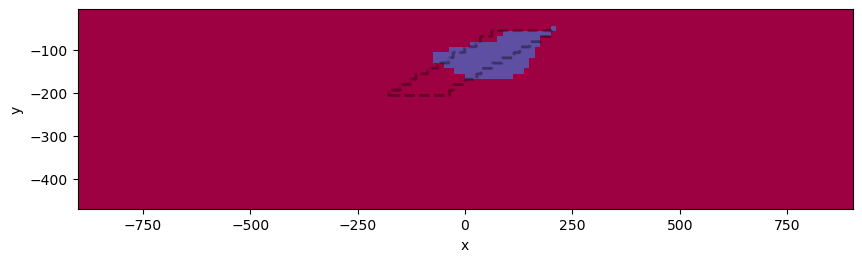

In [26]:
import pylops
import pyproximal
ii = 29
m = np.load(f'admm_iter/model_{ii}.npy')

W = (
    sp.diags(meshCore.cell_volumes**2) * meshCore.average_face_to_cell
)

# g = W @ meshCore.cell_gradient @ m
# z = np.load(f'admm_iter/z_variabe_{ii}.npy')

# We consider now the TV norm. 
# TV = pyproximal.TV(dims=(meshCore.n_cells, ), sigma=1e0)
# sigma = .2
# l1iso = pyproximal.L21(ndim=2, sigma=sigma)
sigma = 1e0
kappa = 1e0
ms_relaxed = pyproximal.proximal.RelaxedMumfordShah(sigma=sigma, kappa=kappa)

tau = 1e-4
# xp = TV.prox(g, tau)
# xp = l1iso.prox(m, tau)
xp = ms_relaxed.prox(m, tau)

cl = np.array([np.log(1/380), np.log(1/30)])
ncl = len(cl)
segpd_prob, segpd = \
    pyproximal.optimization.segmentation.Segment(xp, cl, 1., 0.01,
                                                 niter=10, show=True,
                                                 kwargs_simplex=dict(engine='numba'))


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
meshCore.plot_image(segpd, ax=ax, pcolor_opts={'cmap':'Spectral'})
ax.axis('equal')
utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)
# plt.figure(figsize=(7, 2))
# plt.plot(x, x, 'k', lw=2, label='x')
# plt.plot(x, xp, 'r', lw=2, label='prox(x)')
# plt.xlabel('x')
# plt.title(r'$||x||_{TV}$')
# plt.legend()
# plt.tight_layout()

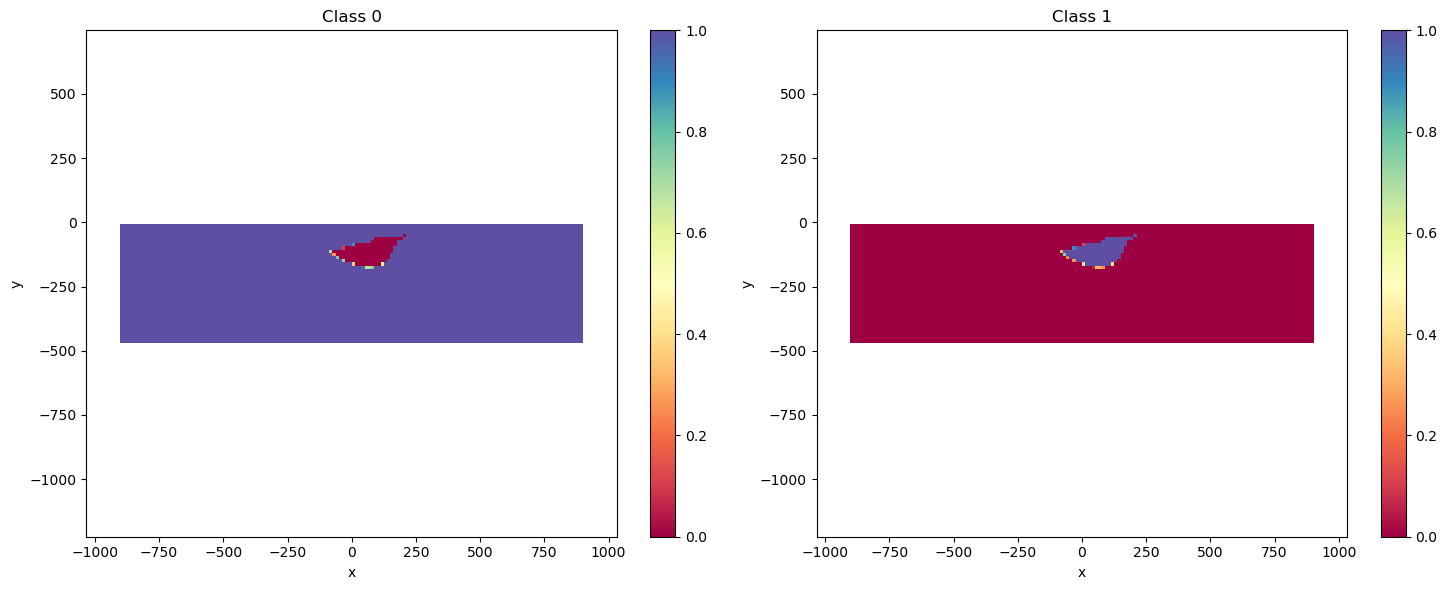

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i, ax in enumerate(axs):
    # ax.imshow(segpd_prob[:, i].reshape(gt.shape), cmap='Reds')
    dd = meshCore.plot_image(segpd_prob[:, i], ax=ax, pcolor_opts={'cmap':'Spectral'})
    axs[i].axis('equal')
    axs[i].set_title(f"Class {i}")
    plt.colorbar(dd[0], ax=ax)
plt.tight_layout()

In [28]:
segpd.max()

1

Loaded dictionary: {'phi_d': [7005.860988792912, 4974.679767407851, 3864.8184783523284, 3513.6378054638526, 3461.6322862629117, 3235.96881819303, 3234.940059657966, 3101.9877977006627, 3058.66906960597, 3044.725099365676, 3025.445047001572, 3022.64758684914, 3009.698041149845, 3002.0461533538733, 2995.1708435960168, 2992.6669497899416, 2983.3470222070314, 2977.5995013761158, 2972.315051122163, 2968.119371250626, 2962.857608341965, 2961.264871446766, 2954.8702995061153, 2951.426892939943, 2948.1767052770765, 2946.2190269437406, 2943.1680415586497, 2940.6547401493776, 2937.8817744414846, 2935.15363679098], 'beta': 1.0, 'gamma': 1e-05, 'norm_residual': [0.0007876547467002892, 2.0392359267677295e-05, 6.130032063850201e-06, 1.4016990594822183e-05, 4.801681367806013e-06, 6.1001866226972085e-06, 4.751438679835893e-06, 3.482468840289551e-06, 3.0699127030800866e-06, 2.4668939866284574e-06, 1.3101563795157768e-06, 1.705651630026462e-06, 1.0401441647354494e-06, 1.880985154403744e-06, 9.9298418283

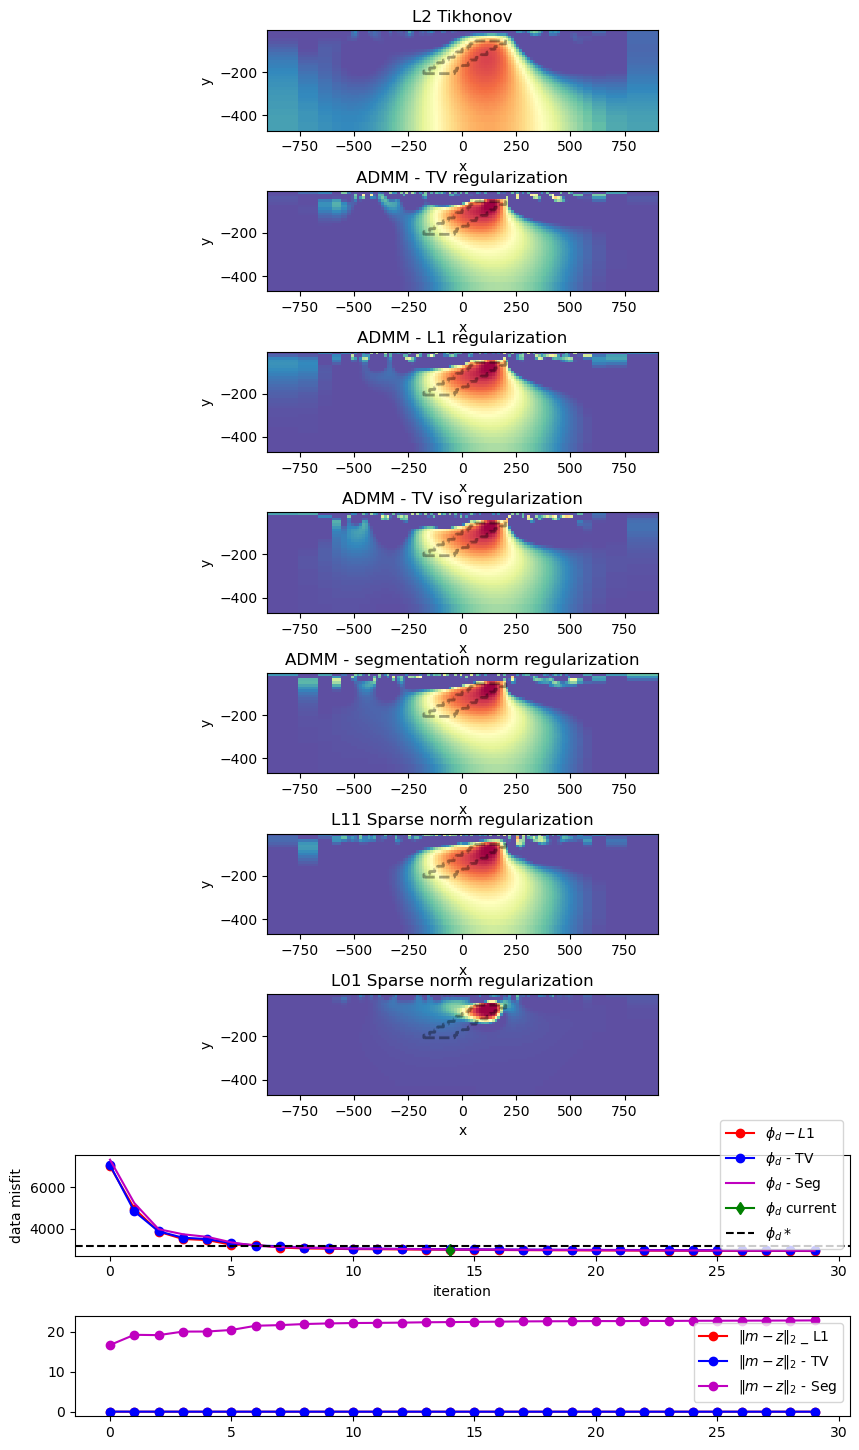

In [59]:
import json

# Load dictionary from a JSON file
with open('/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_tviso/phi_d.json', 'r') as file:
    loaded_data = json.load(file)

print("Loaded dictionary:", loaded_data)
phi_d = loaded_data['phi_d']
contraint = loaded_data['norm_residual']

# Load dictionary from a JSON file
with open('/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_tv_1e-3/phi_d.json', 'r') as file:
    loaded_data = json.load(file)

print("Loaded dictionary:", loaded_data)
phi_d_tv = loaded_data['phi_d']
contraint_tv = loaded_data['norm_residual']

# Load dictionary from a JSON file
with open('/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_segnorm_1e-4/phi_d.json', 'r') as file:
    loaded_data = json.load(file)

print("Loaded dictionary:", loaded_data)
phi_d_seg = loaded_data['phi_d']
contraint_seg = loaded_data['norm_residual']

ii = 14
m = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_tv_1e-3/model_{ii}.npy')
mtviso = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_tviso/model_{ii}.npy')
# z = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter/z_variabe_{ii}.npy')

m2 = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/iterations_l2_practical/model_{14}.npy')
m1 = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_l1_proxop/model_{ii}.npy')
msparse = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/iterations_l11/model_{11}.npy')
msparse0 = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/iterations_L01/model_{7}.npy')
mseg = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_segnorm_1e-4/model_{ii}.npy')


fig, ax = plt.subplots(9, 1, figsize=(10, 18))
meshCore.plot_image(1/ np.exp(m2), ax=ax[0], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
meshCore.plot_image(1/ np.exp(m), ax=ax[1], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
# meshCore.plot_image(m - m1, ax=ax[1], pcolor_opts={'cmap':'Spectral'})
meshCore.plot_image(1/ np.exp(m1), ax=ax[2], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
meshCore.plot_image(1/ np.exp(mtviso), ax=ax[3], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
meshCore.plot_image(1/ np.exp(mseg), ax=ax[4], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
meshCore.plot_image(1/ np.exp(msparse), ax=ax[5], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
meshCore.plot_image(1/ np.exp(msparse0), ax=ax[6], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
ax[0].axis('equal')
ax[1].axis('equal')
ax[2].axis('equal')
ax[4].axis('equal')
ax[3].axis('equal')
ax[5].axis('equal')
ax[0].set_title('L2 Tikhonov')
ax[1].set_title('ADMM - TV regularization')
ax[2].set_title('ADMM - L1 regularization')
ax[3].set_title('ADMM - TV iso regularization')
ax[4].set_title('ADMM - segmentation norm regularization')
ax[5].set_title('L11 Sparse norm regularization')
ax[6].set_title('L01 Sparse norm regularization')
# ax[2].hist(m - z, 100)
# ax[2].set_title('contraint (m - z = 0)')
# ax[2].hist(1/ np.exp(m), 100, label='z', alpha=0.4)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)
utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)
utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[3],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)
utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[4],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[5],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[6],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--', 'alpha':0.2},
    method='nearest'
    
)

ax[7].plot(phi_d, '-or', label=r'$\phi_d - L1$')
ax[7].plot(phi_d_tv, '-ob', label=r'$\phi_d$ - TV')
ax[7].plot(phi_d_seg, '-m', label=r'$\phi_d$ - Seg')
ax[7].plot(ii, phi_d[ii], '-dg', label=r'$\phi_d$ current')
ax[8].plot(contraint, '-or', label=r'$\|m-z\|_2$ _ L1')
ax[8].plot(contraint_tv, '-ob', label=r'$\|m-z\|_2$ - TV')
ax[8].plot(contraint_seg, '-om', label=r'$\|m-z\|_2$ - Seg')
ax[7].axhline(dc_data.dobs.shape[0], color='k', linestyle='--', label=r'$\phi_d*$')
# ax[2].set_ylim([0, 3000])
ax[7].legend()
ax[8].legend()
ax[7].set_xlabel('iteration')
ax[7].set_ylabel('data misfit')
plt.subplots_adjust(hspace=0.6, wspace=0.5)
plt.show()

## Plotting ADMM Inversion Results Per iteration

Loaded dictionary: {'phi_d': [7321.875161913901, 5238.630697559707, 3984.966222868414, 3740.454408568304, 3616.2565568669906, 3349.913838124947, 3186.819393980296, 3128.0399316378907, 3101.3475336262386, 3071.9817397216666, 3050.6421210290473, 3043.1448952163937, 3031.147219965515, 3022.922805509285, 3012.9127846188817, 3007.0696448784283, 3000.521796103266, 2994.3245774638367, 2988.473109829692, 2984.9496404990905, 2978.740830923487, 2973.71948234694, 2969.830872286417, 2966.9634635301913, 2962.7153568542044, 2962.1586714282716, 2957.639801540037, 2956.030779915206, 2952.5047961007417, 2950.6488176706825], 'beta': 1.0, 'gamma': 1e-05, 'norm_residual': [16.68618046078333, 19.23443951909725, 19.156566322531674, 20.042126025683718, 20.05982107039527, 20.449690446584672, 21.503751157664308, 21.66040717036492, 21.932192948801397, 22.085686921373906, 22.181878376136122, 22.22100759405345, 22.282525692320473, 22.37322693281613, 22.420966894087925, 22.47143095877717, 22.52476044398474, 22.589

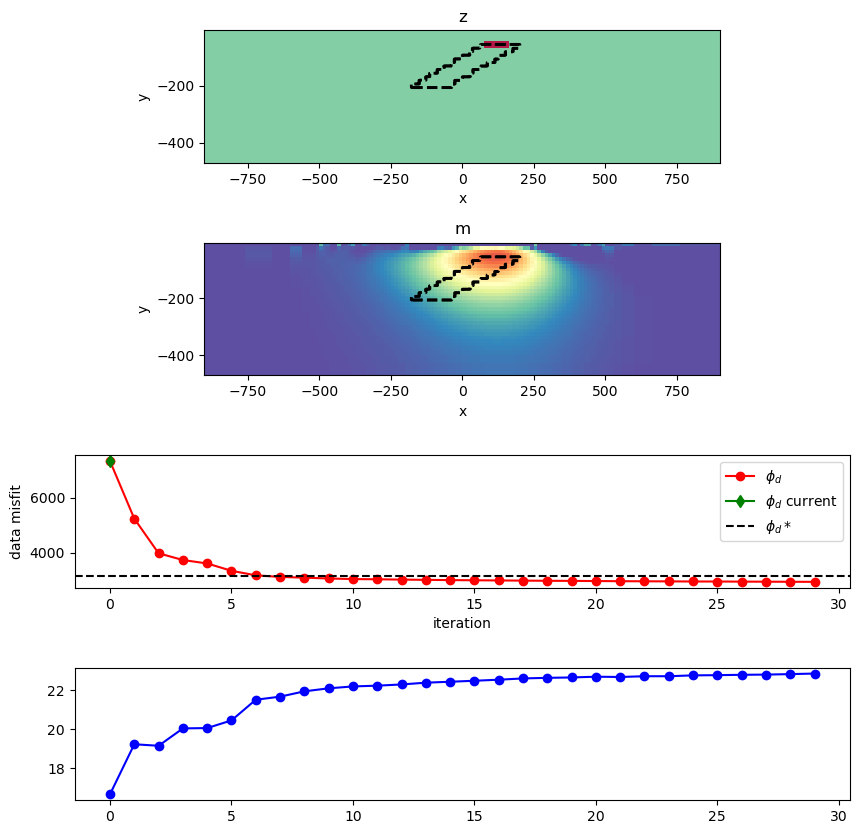

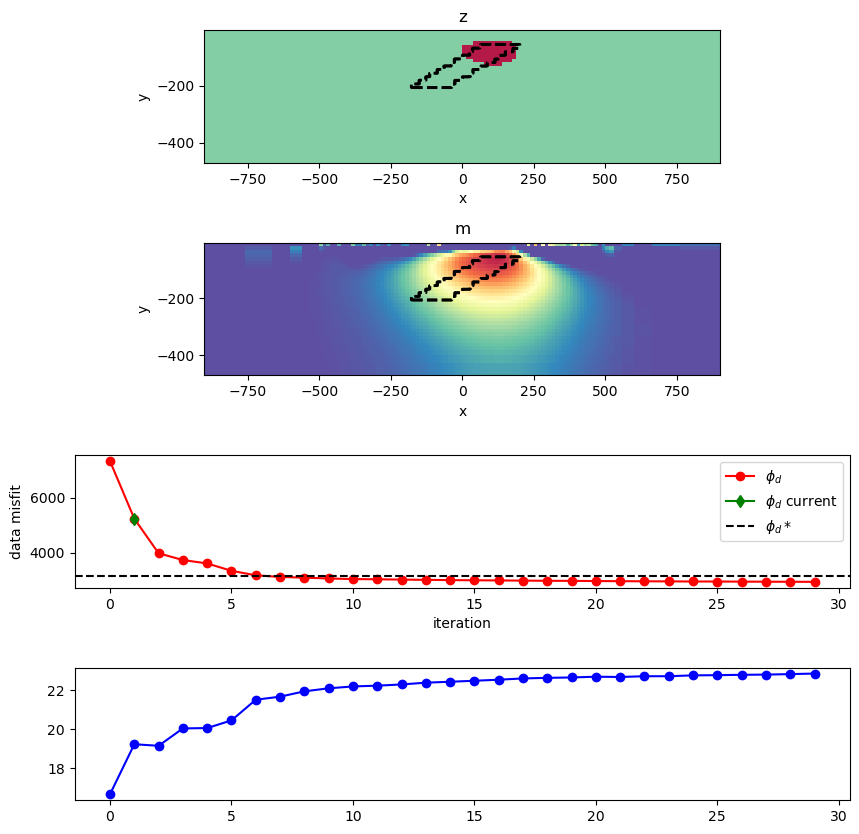

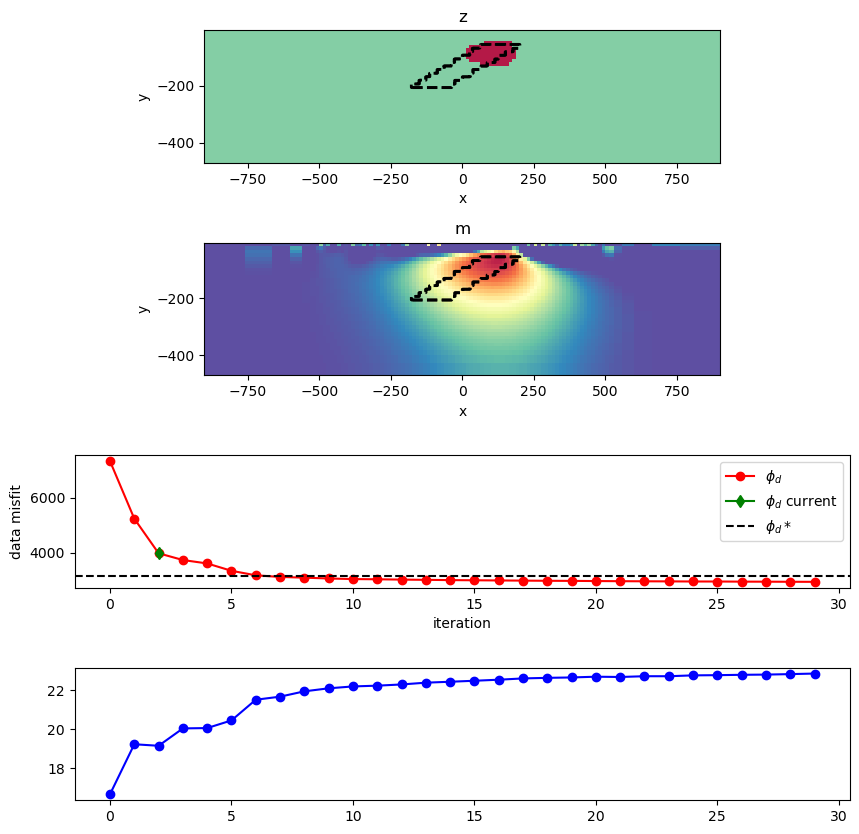

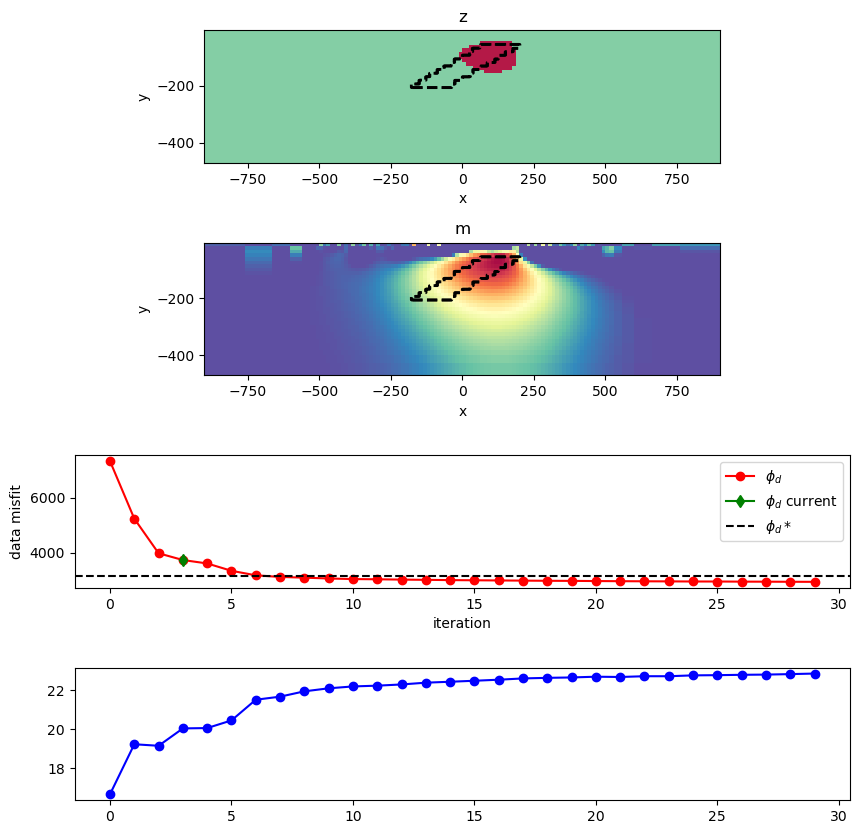

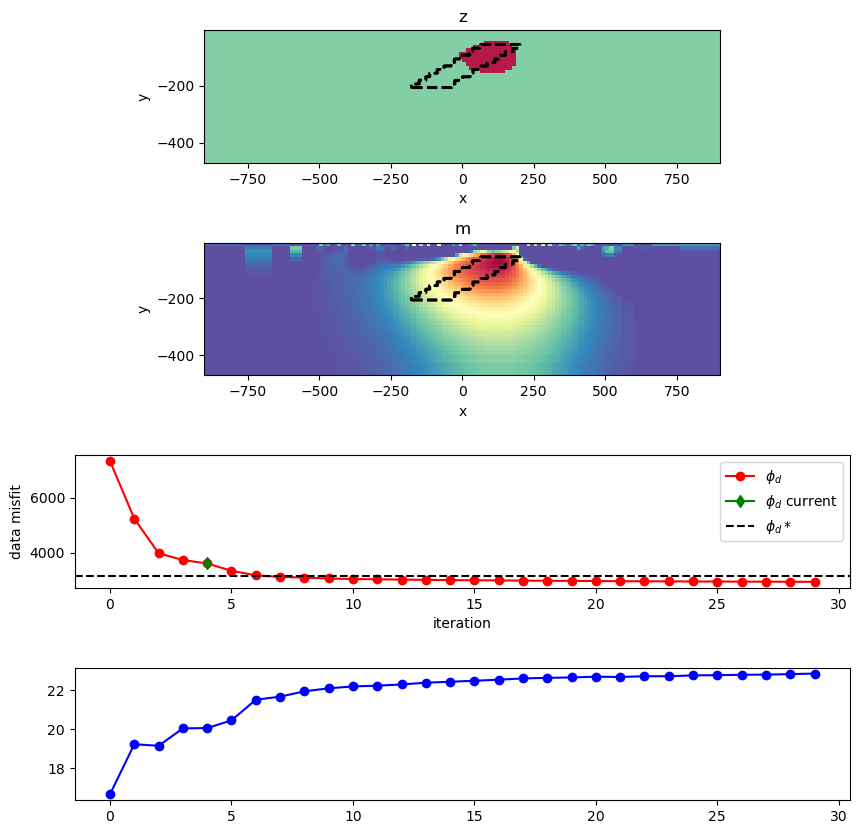

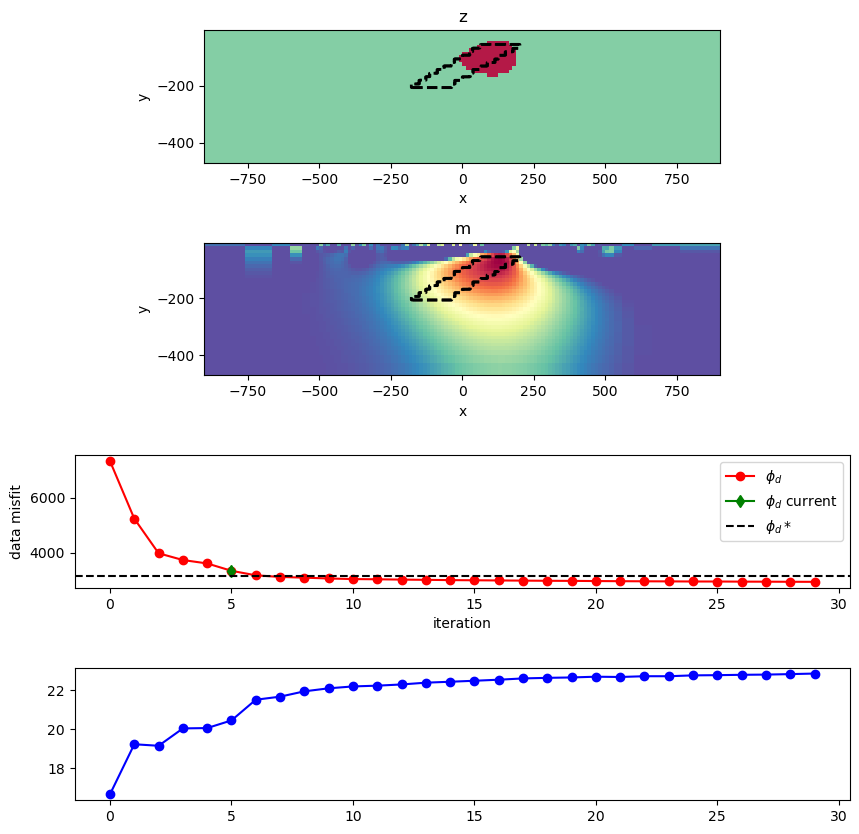

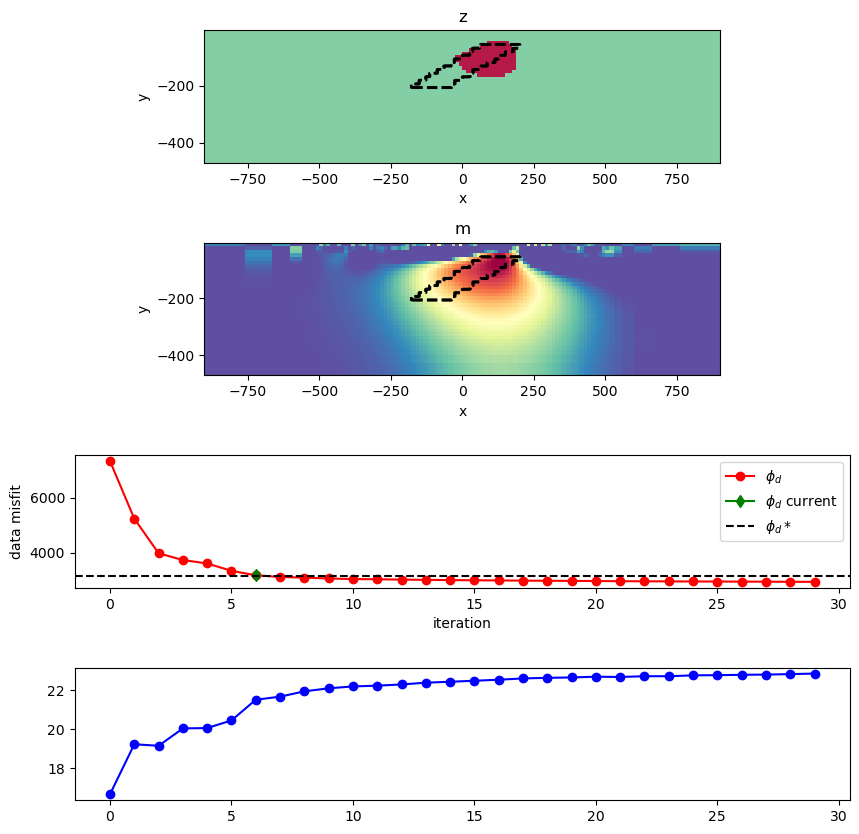

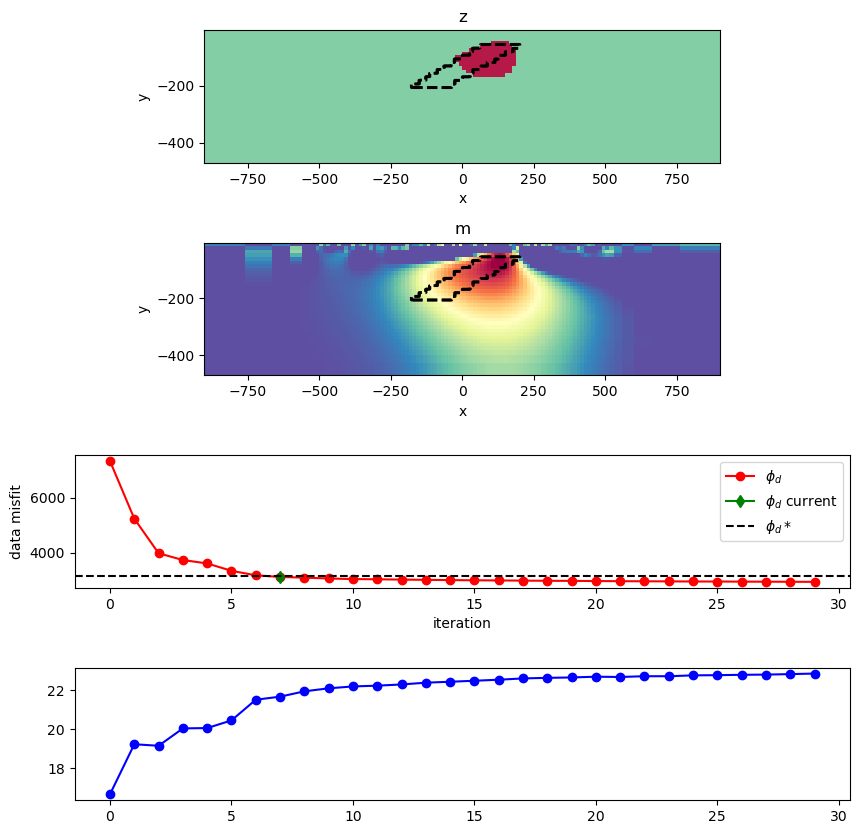

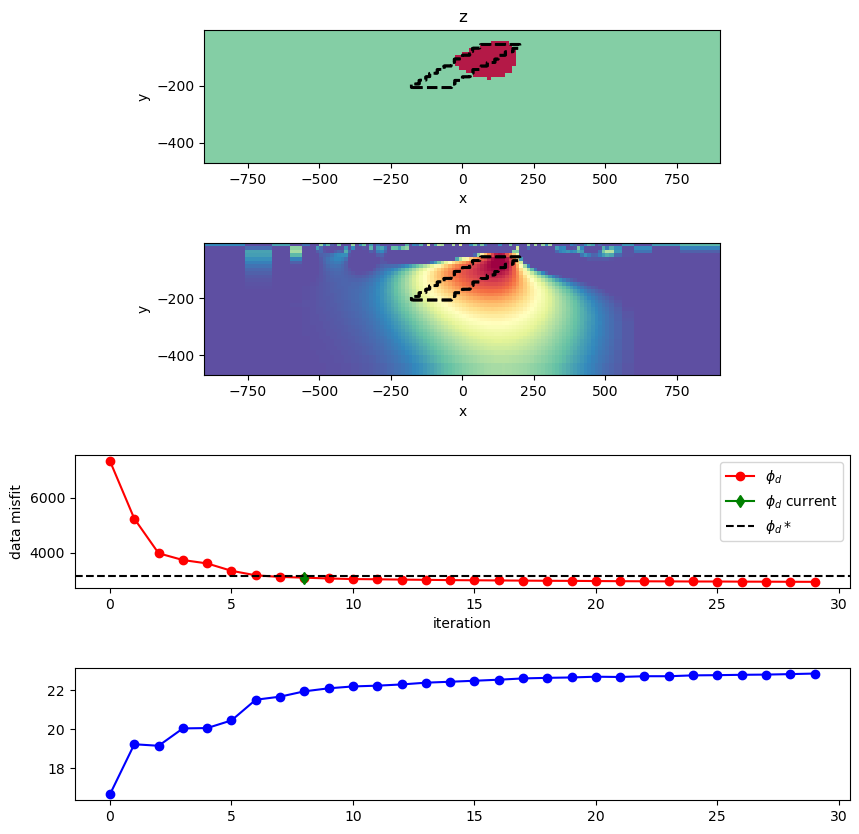

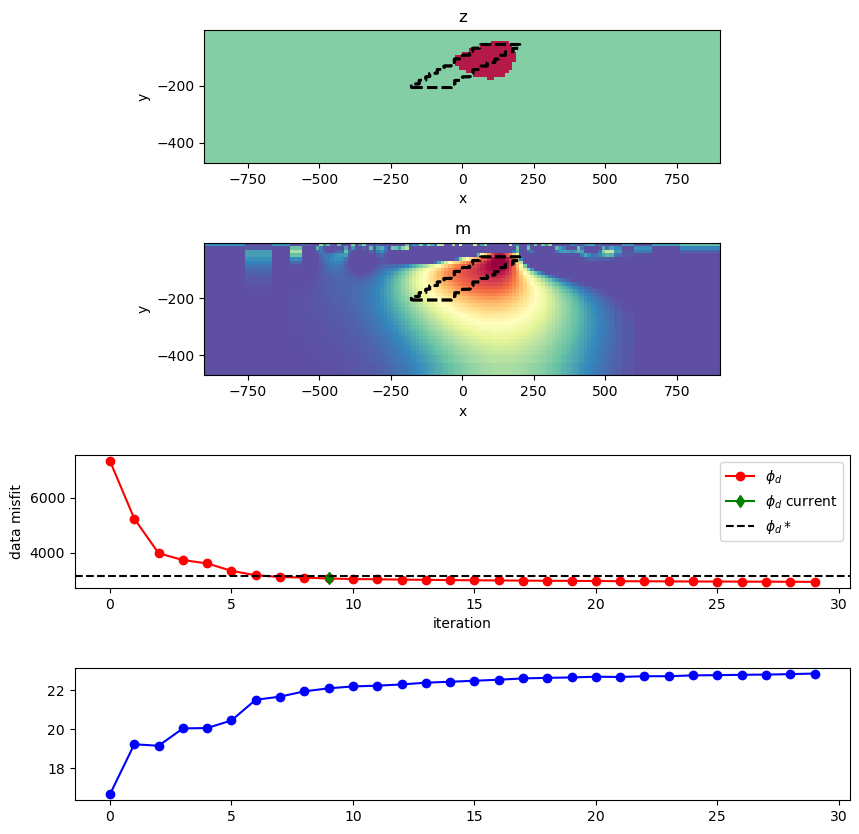

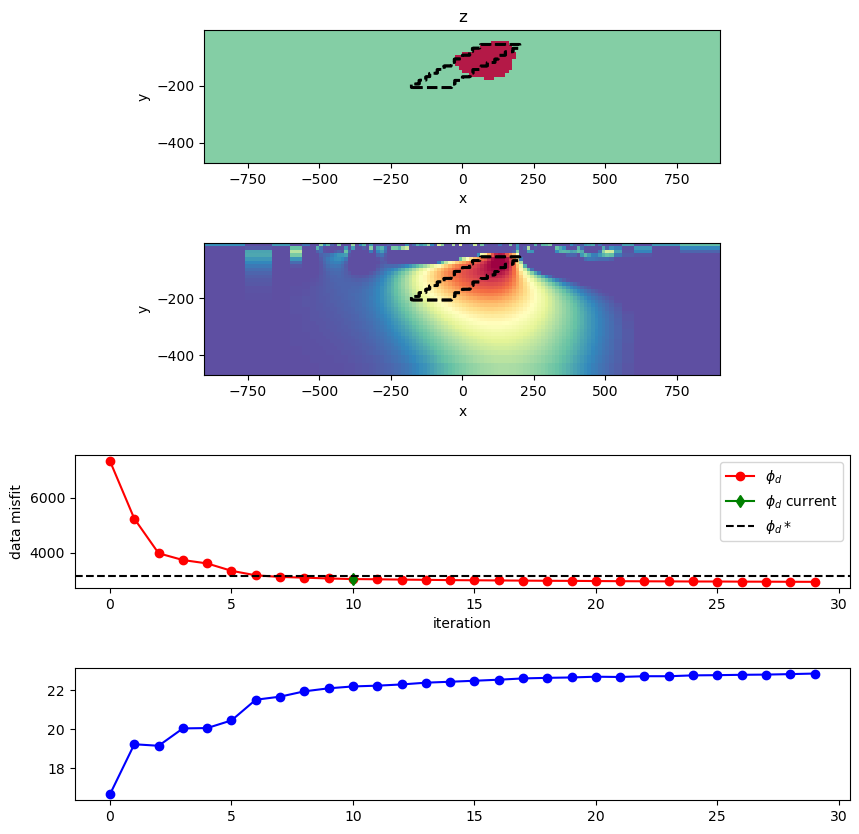

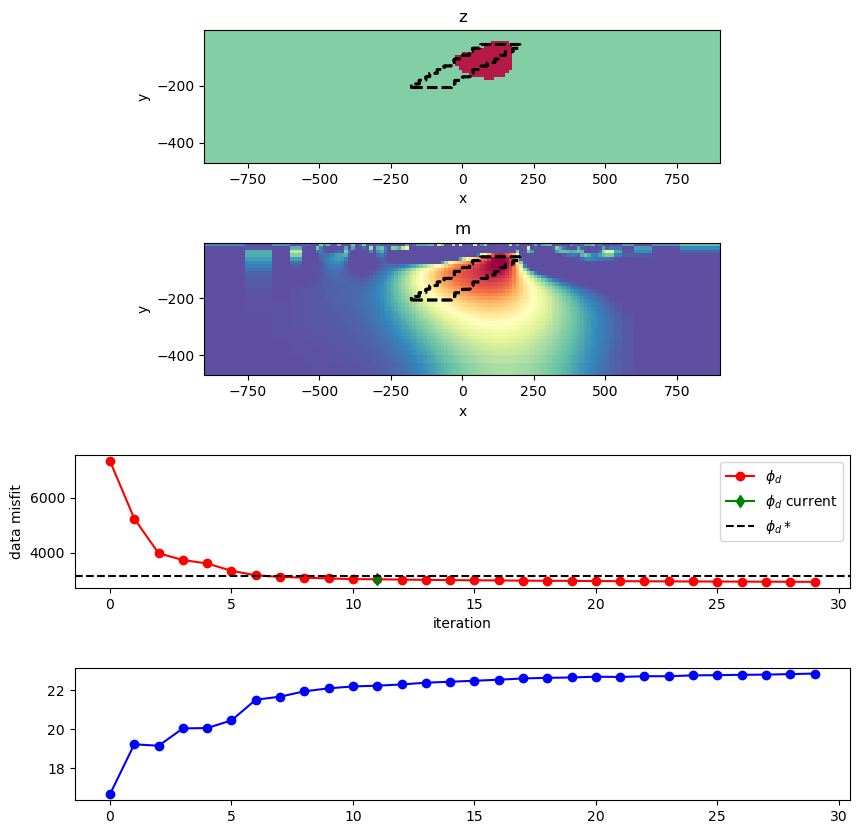

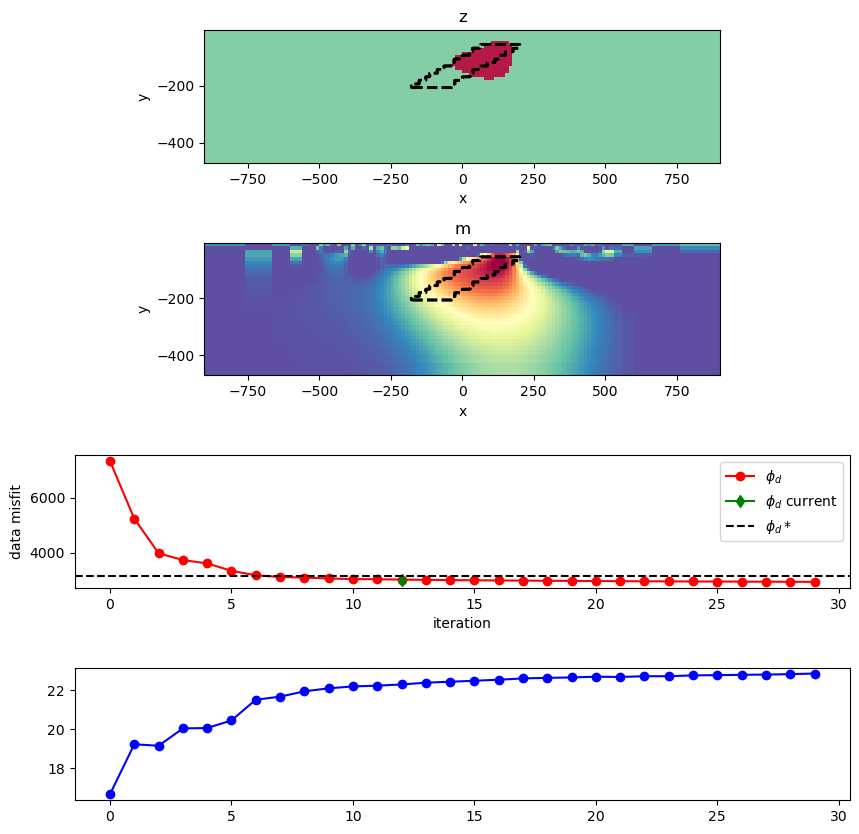

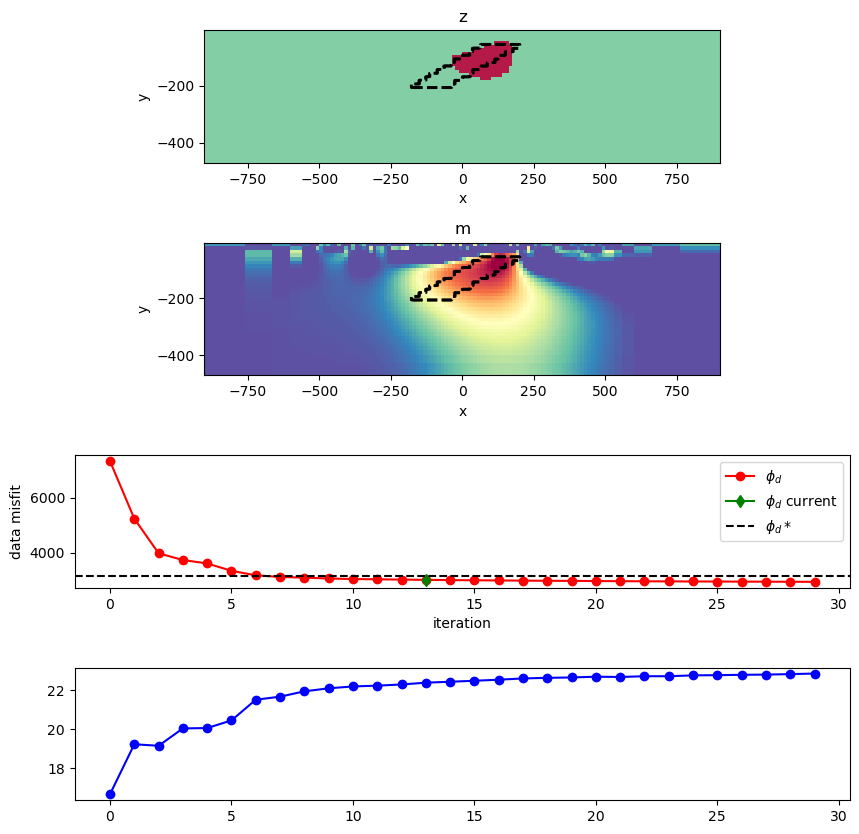

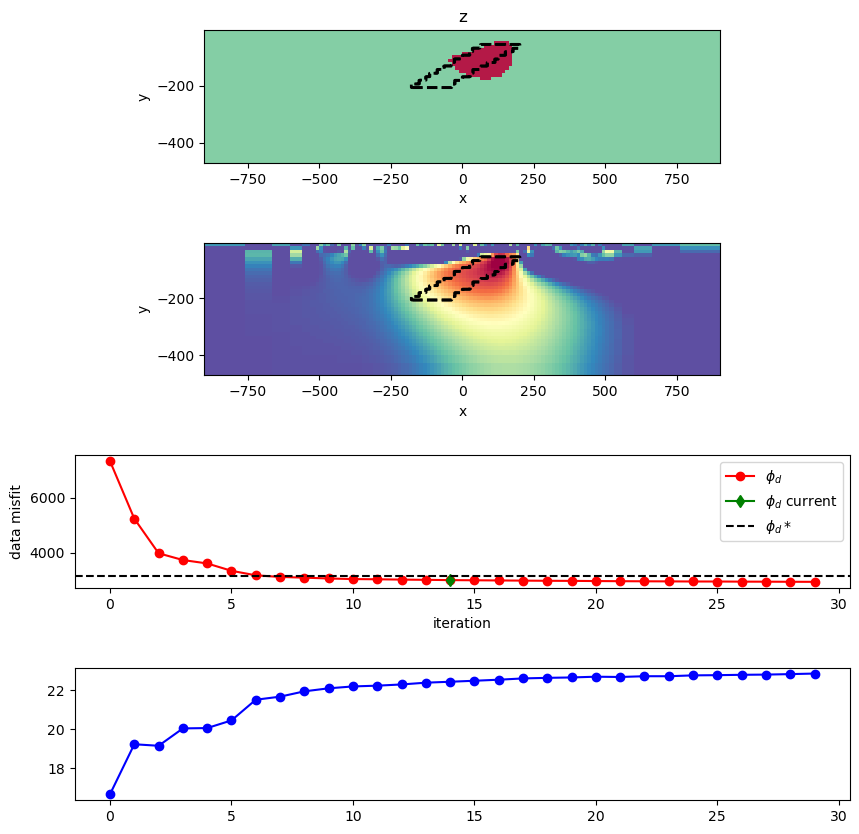

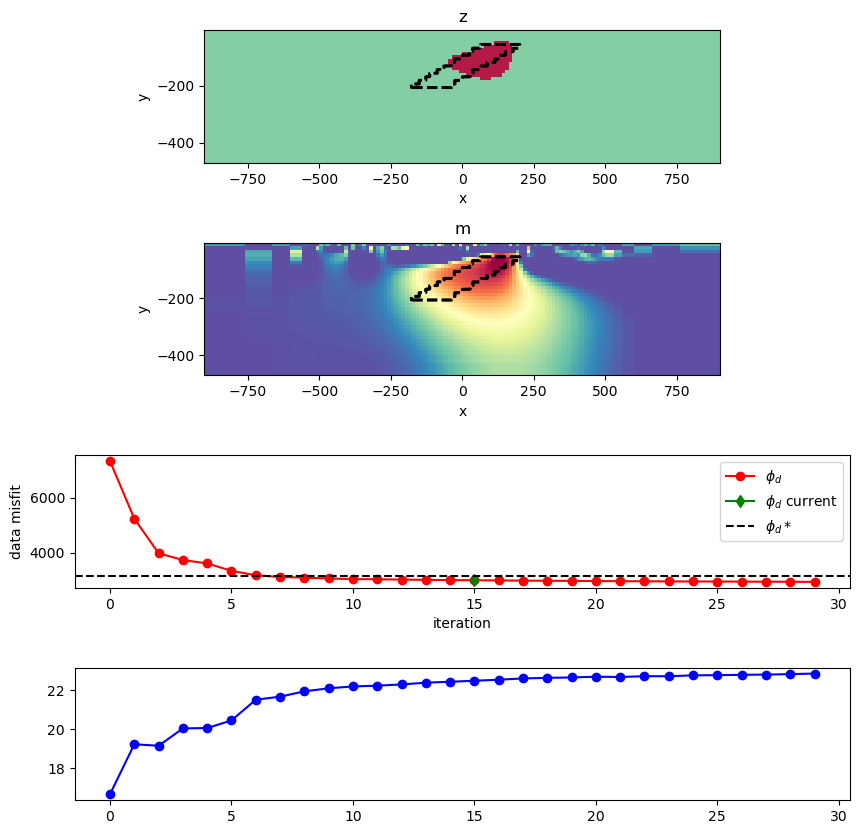

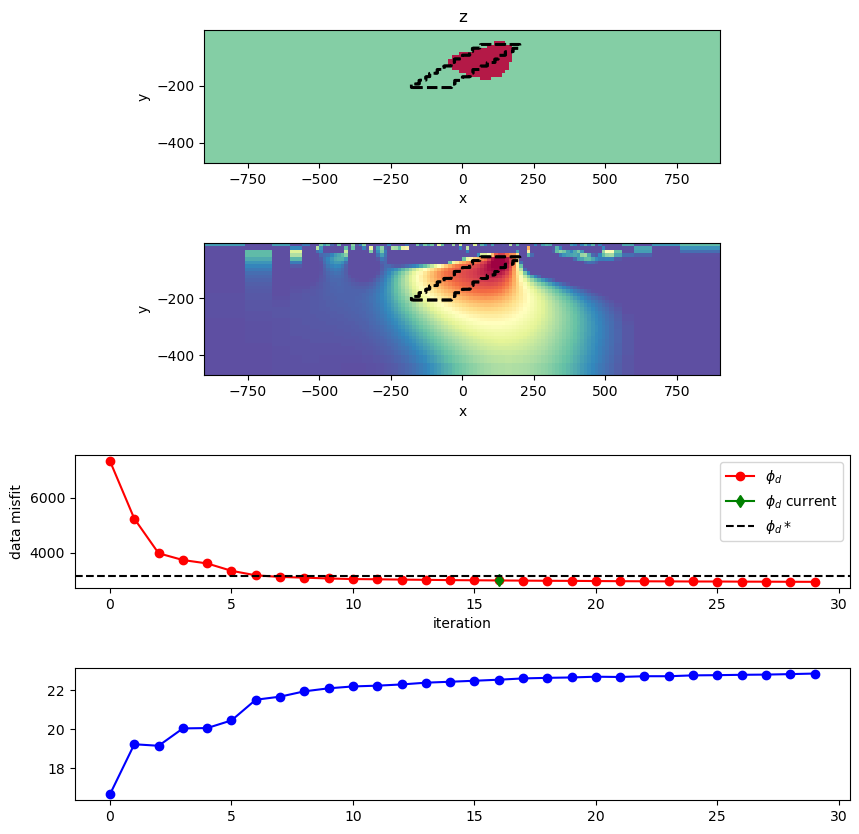

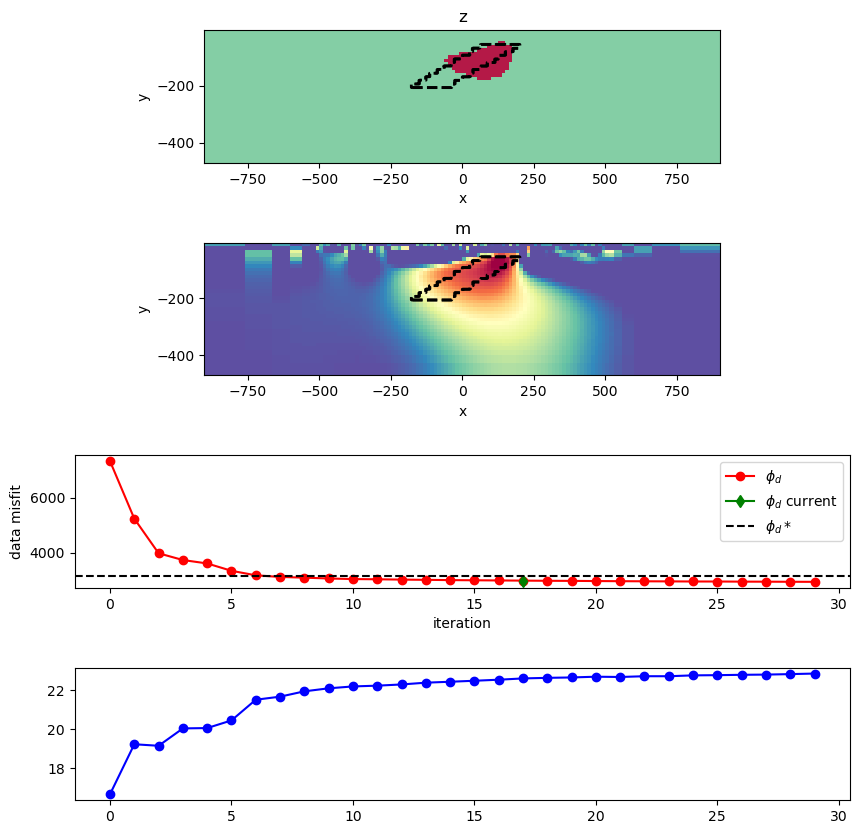

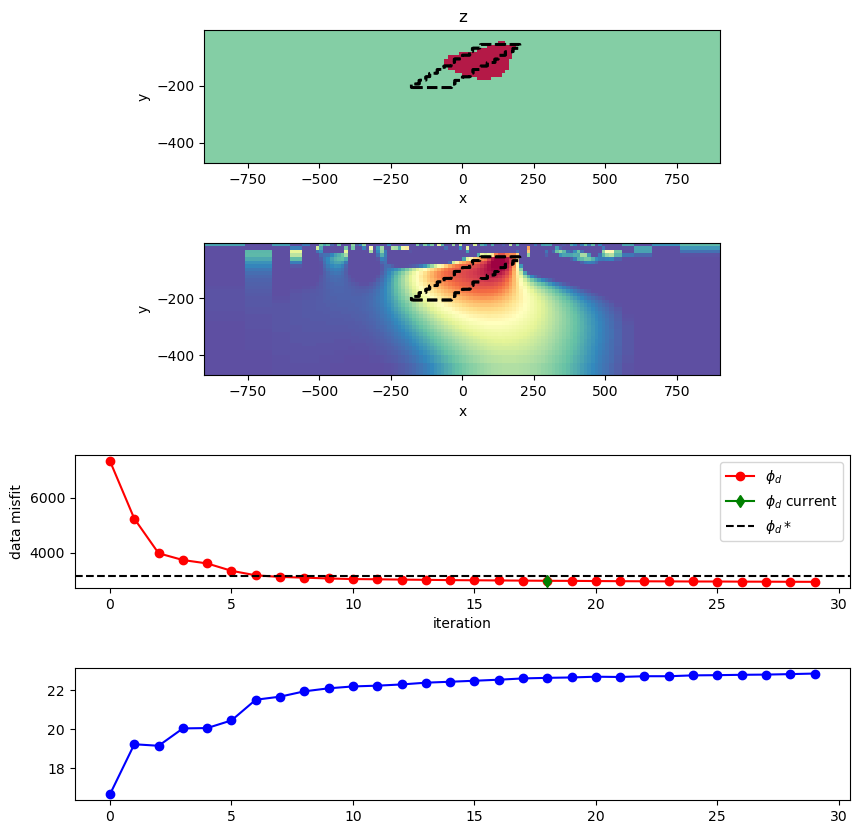

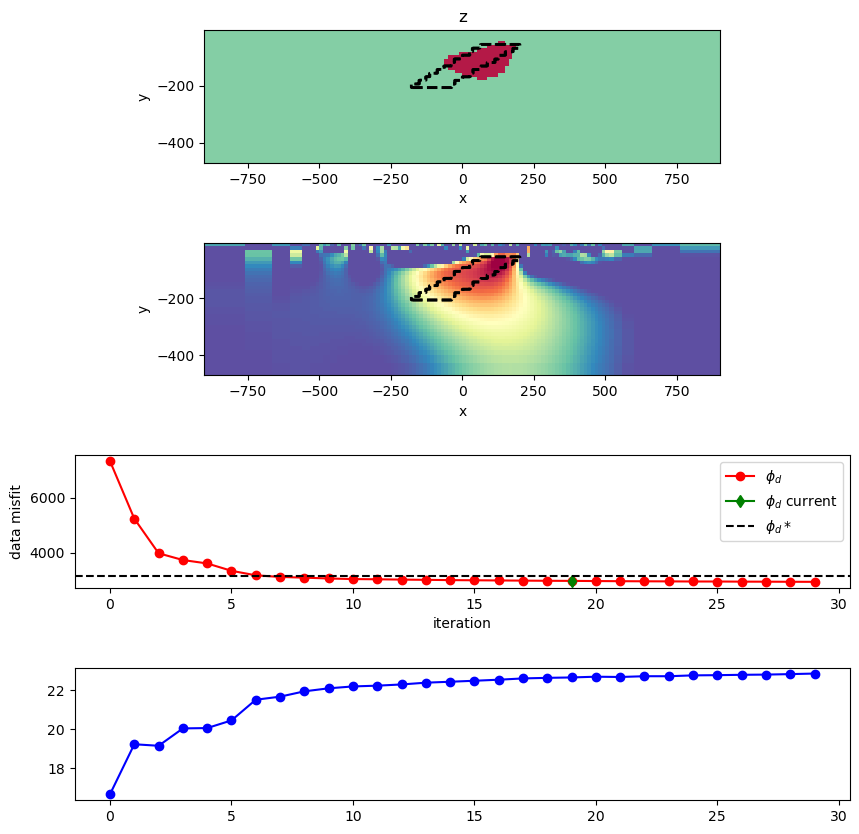

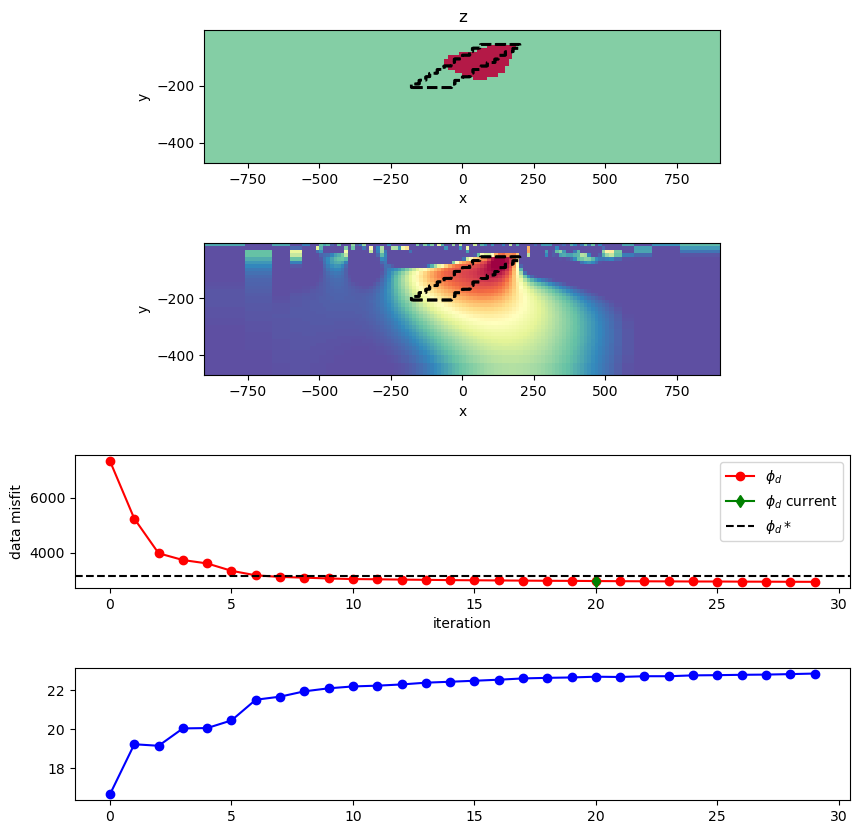

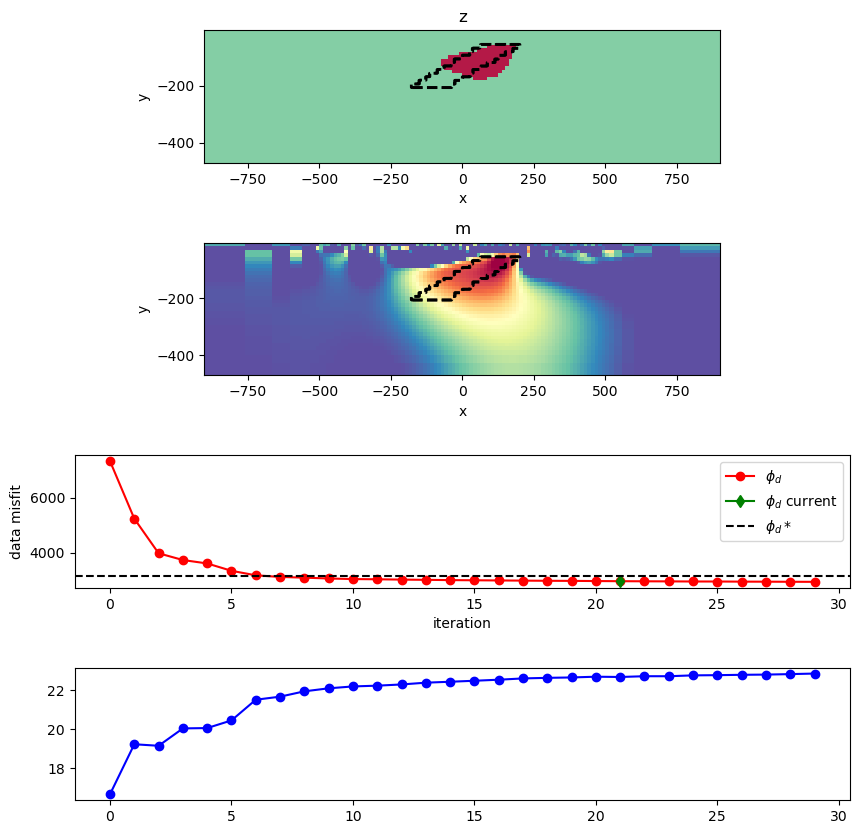

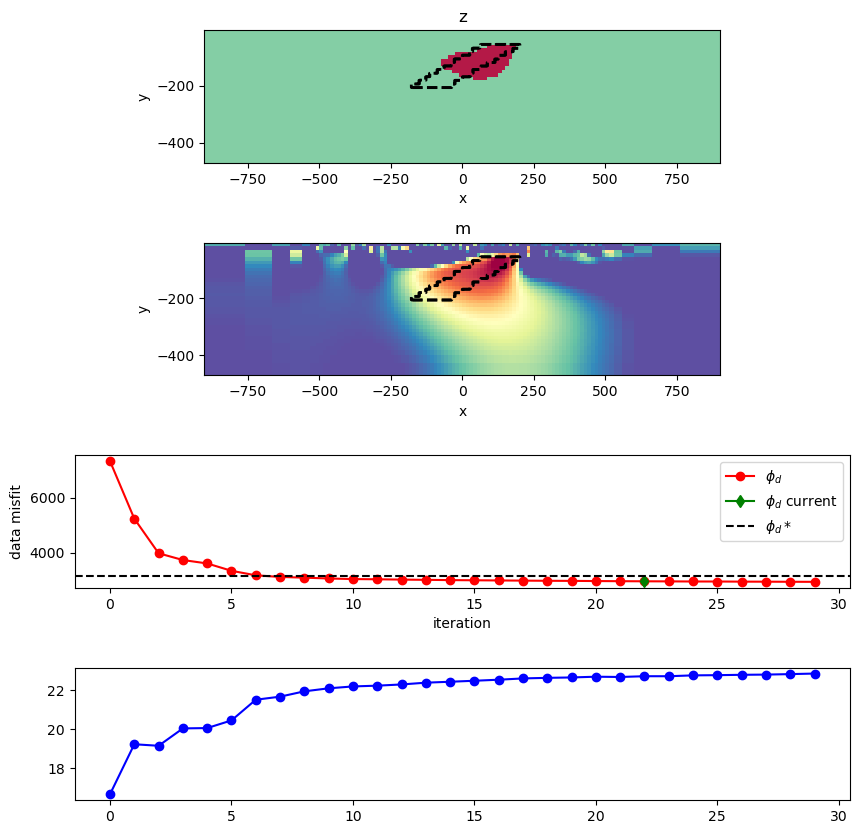

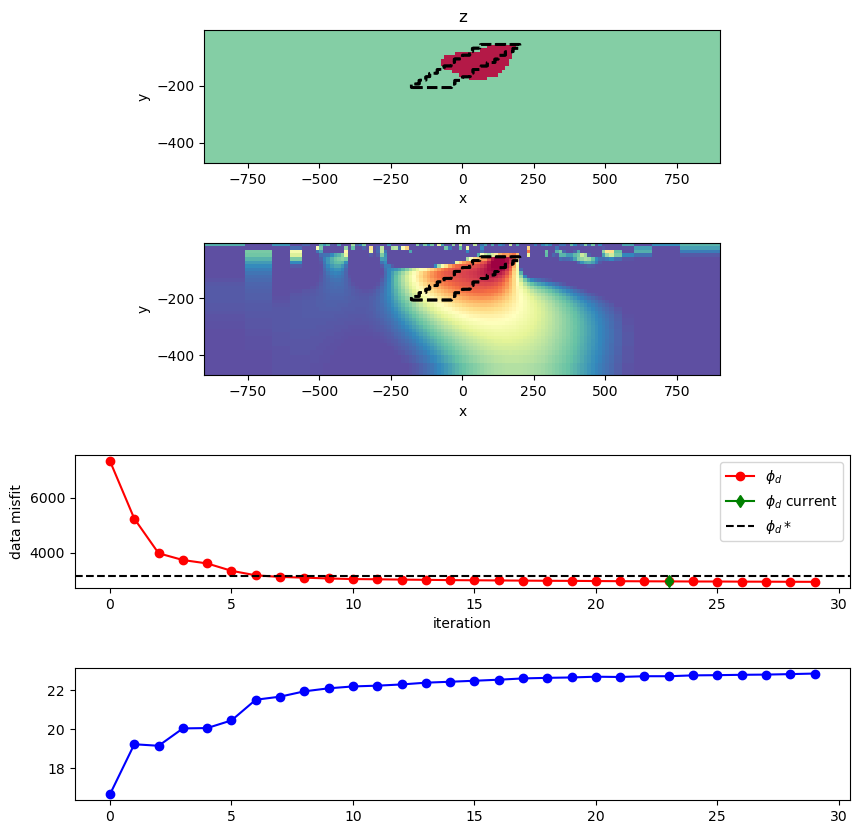

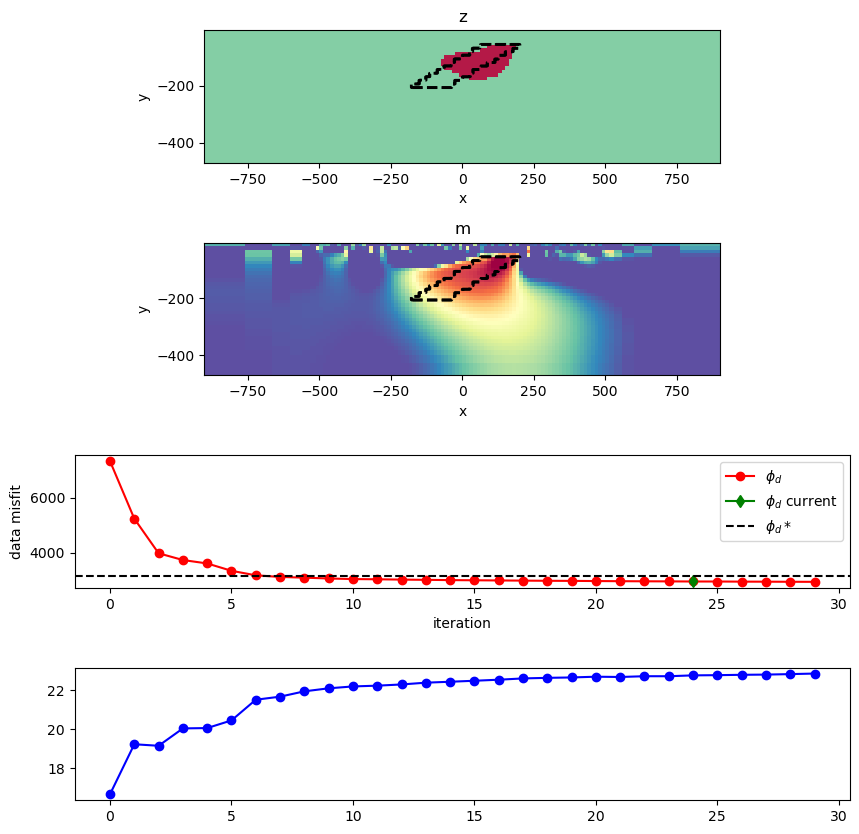

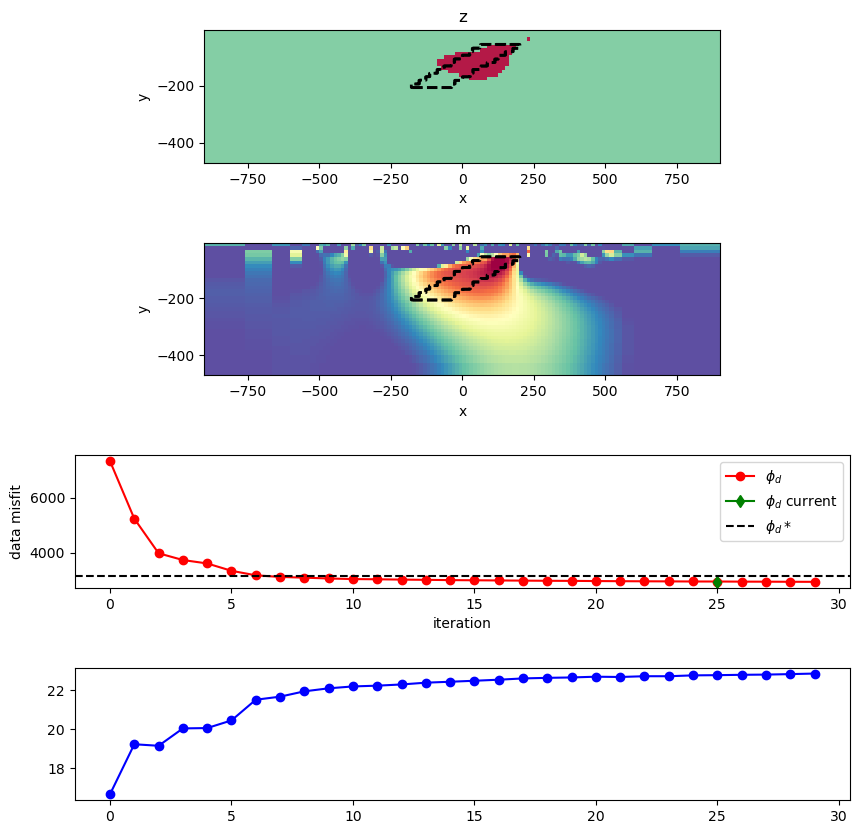

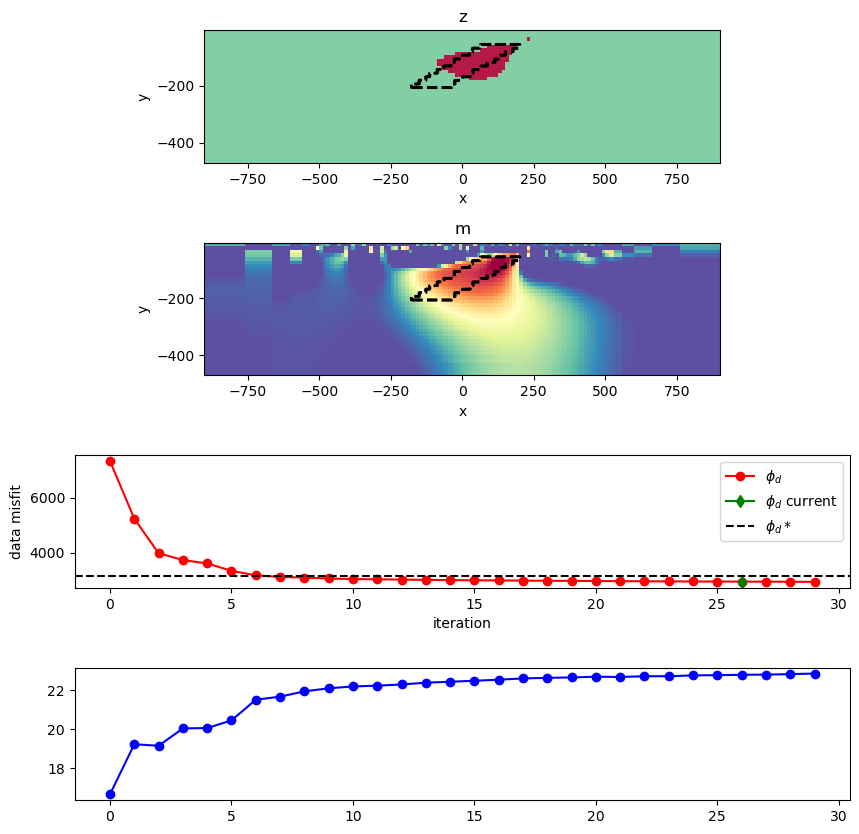

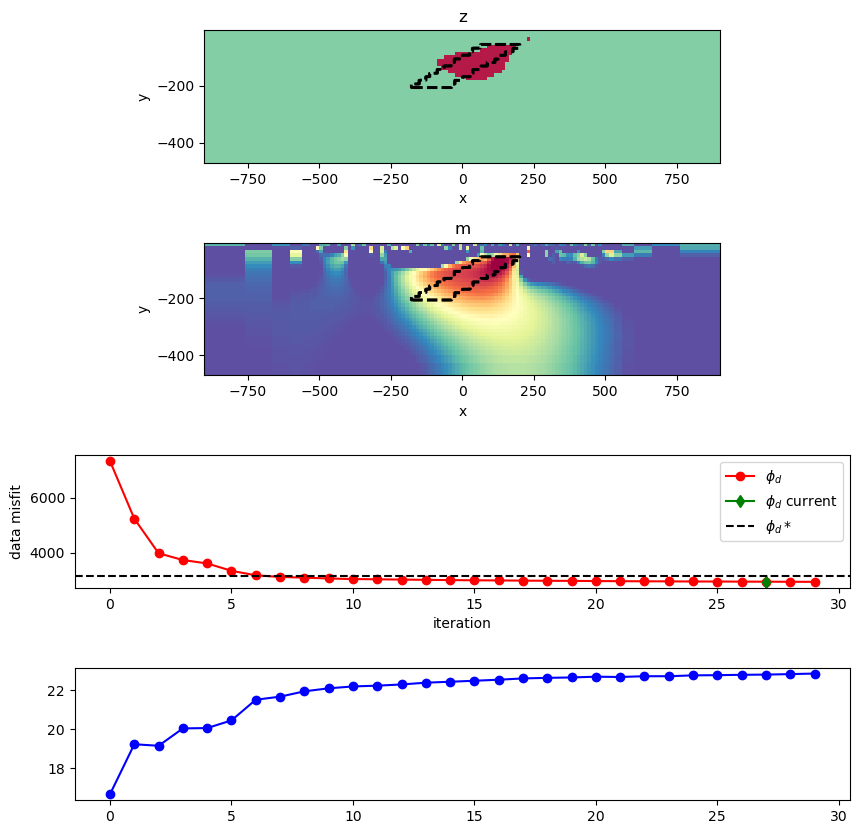

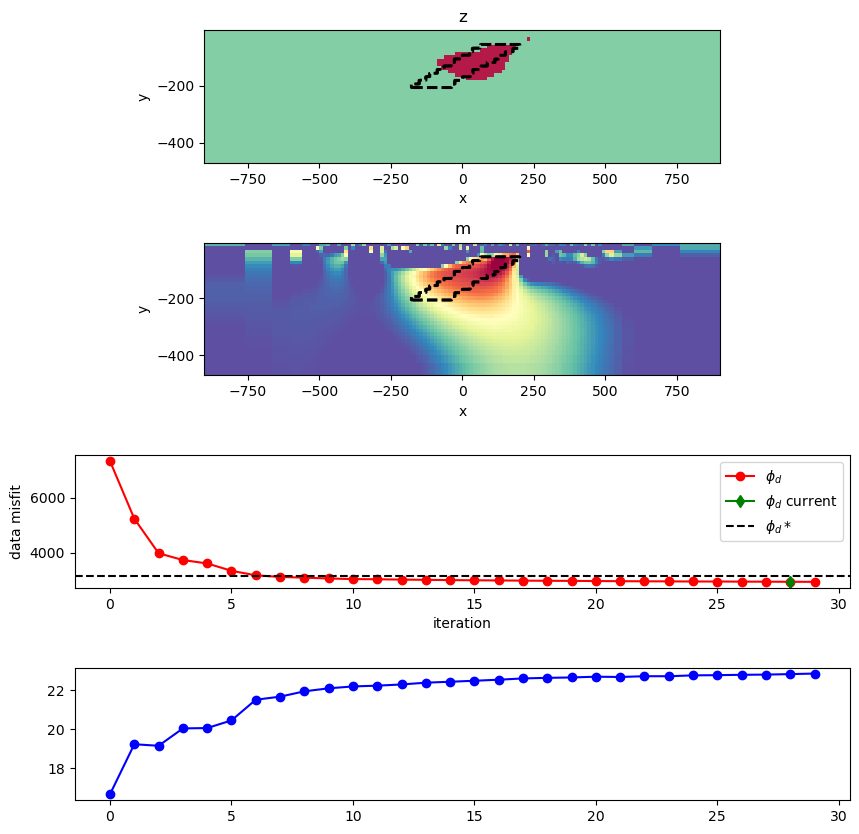

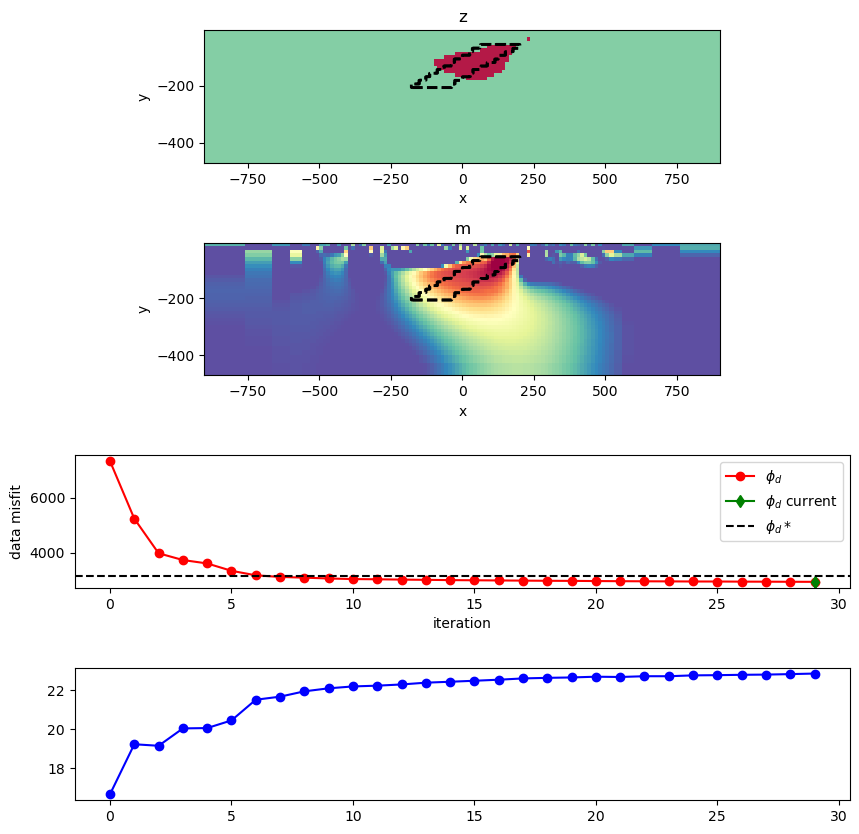

In [60]:
# phi_d = []
errors = []
u = np.zeros_like(mtrue[actcore])
import json

# Load dictionary from a JSON file
with open('/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_segnorm_1e-4/phi_d.json', 'r') as file:
    loaded_data = json.load(file)

print("Loaded dictionary:", loaded_data)
phi_d = loaded_data['phi_d']
contraint = loaded_data['norm_residual']
ii = 0
for ii in range(30):
    
    m = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_segnorm_1e-4/model_{ii}.npy')
    z = np.load(f'/home/juanito/Dropbox/JohnLindsey/geoseg/admm_iter_segnorm_1e-4/z_variabe_{ii}.npy')
    u += m - z
    # phi_d += [dmis(m)]
    # errors += [np.linalg.norm(u)]
    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    meshCore.plot_image(1/ np.exp(z), ax=ax[0], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
    meshCore.plot_image(1/ np.exp(m), ax=ax[1], pcolor_opts={'cmap':'Spectral'}, clim=[10, 500])
    ax[0].axis('equal')
    ax[1].axis('equal')
    ax[0].set_title('z')
    ax[1].set_title('m')
    # ax[2].hist(m - z, 100)
    # ax[2].set_title('contraint (m - z = 0)')
    # ax[2].hist(1/ np.exp(m), 100, label='z', alpha=0.4)

    utils.plot2Ddata(

        meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
        contourOpts={'alpha':0},
        #clim=[0,5],
        ax=ax[0],
        level=True,
        ncontour=2,
        levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        method='nearest'
        
    )

    utils.plot2Ddata(

        meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
        contourOpts={'alpha':0},
        #clim=[0,5],
        ax=ax[1],
        level=True,
        ncontour=2,
        levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        method='nearest'
        
    )
    ax[2].plot(phi_d, '-or', label=r'$\phi_d$')
    ax[2].plot(ii, phi_d[ii], '-dg', label=r'$\phi_d$ current')
    ax[3].plot(contraint, '-ob', label=r'$\|m-z\|_2$')
    ax[2].axhline(dc_data.dobs.shape[0], color='k', linestyle='--', label=r'$\phi_d*$')
    # ax[2].set_ylim([0, 3000])
    ax[2].legend()
    ax[2].set_xlabel('iteration')
    ax[2].set_ylabel('data misfit')
    plt.subplots_adjust(hspace=0.6, wspace=0.5)
    plt.show()

## This is something else

In [50]:
from sklearn.decomposition import PCA
ii = 12
z = np.load(f'admm_iter/z_variabe_{ii}.npy')
# print(z)
m = np.load(f'admm_iter/model_{ii}.npy')

seg_data = z.reshape((len(meshCore.h[0]), len(meshCore.h[1])), order='F')
# Find the coordinates of the object pixels
object_pixels = np.argwhere(seg_data > np.log(1/370))

# Apply PCA to determine orientation
if len(object_pixels) > 1:

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {180 - angle_degrees} {pca.singular_values_}")
    angle_radians = angle_degrees * np.pi / 180

Orientation angle (degrees): 346.869718562228 [44.24064788 24.54930923]


In [ ]:
models_geo = '/home/juanito/Documents/git/StructuralGeo/code_examples/model_test3_1.npy'
models_geo_locs = '/home/juanito/Documents/git/StructuralGeo/code_examples/model_test3_locs_1.npy'

geo_model = np.load(models_geo)
geo_model_locs = np.load(models_geo_locs)
print(geo_model_locs*25, geo_model_locs.shape, meshCore.cell_centers)

[[-500.      -500.      -250.     ]
 [-500.      -500.      -246.06299]
 [-500.      -500.      -242.12599]
 ...
 [ 500.       500.       242.12599]
 [ 500.       500.       246.06299]
 [ 500.       500.       250.     ]] (2097152, 3) [[-395. -295.]
 [-390. -295.]
 [-385. -295.]
 ...
 [ 385.   -5.]
 [ 390.   -5.]
 [ 395.   -5.]]


In [ ]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 12.5,  12.5,  12.5
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#


xmin, xmax = -1000., 1000.
ymin, ymax = -500., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)


  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -5,846.74      5,846.74     12.50  1,621.83    1.50
   y     73     -5,584.24          6.25     12.50  1,621.83    1.50




16384


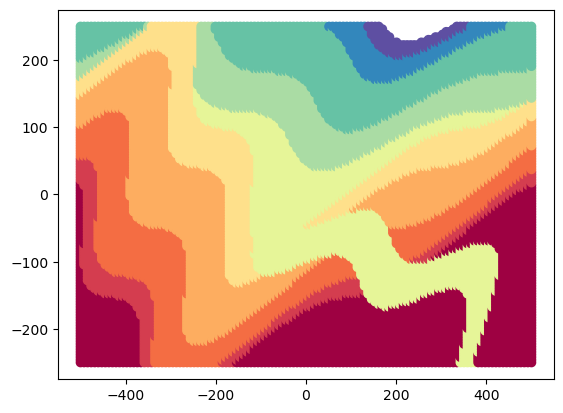

In [ ]:
inds = geo_model_locs[:,1] * 25 == 500
print(inds.sum())
plt.scatter(geo_model_locs[inds,0]*25, geo_model_locs[inds,2]*25, c=geo_model[inds], cmap='Spectral')

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Define the original data points
x = geo_model_locs[inds,0]*25
y = geo_model_locs[inds,2]*25 - np.max(geo_model_locs[inds,2]*25) + 50
values = geo_model[inds]

# Define the new points to interpolate to
new_x = mesh.cell_centers[:,0]
new_y = mesh.cell_centers[:,1]

# Combine x and y into a single array of points
points = np.vstack((x, y)).T

# New points where we want to interpolate the values
new_points = np.vstack((new_x, new_y)).T

# Initialize the NearestNeighbors model
nn = NearestNeighbors(n_neighbors=1)
nn.fit(points)

# Find the nearest neighbors for each new point
distances, indices = nn.kneighbors(new_points)

# Use the indices to get the corresponding values from the original data
interpolated_values = values[indices.flatten()]
# Print the interpolated values
print(interpolated_values)

[1. 1. 1. ... 9. 9. 9.]


In [ ]:
physy_model = np.zeros_like(mesh.cell_centers[:,0]) + 2000

inds_res_bottom = interpolated_values == 6
inds_res_bottom2 = interpolated_values == 5
inds_res_bottom3 = interpolated_values == 4
inds_res_core = interpolated_values == 7
inds_res_lid = interpolated_values == 8

physy_model[inds_res_bottom] = 500
physy_model[inds_res_bottom2] = 300
physy_model[inds_res_bottom3] = 1000
physy_model[inds_res_core] = 10
physy_model[inds_res_lid] = 800



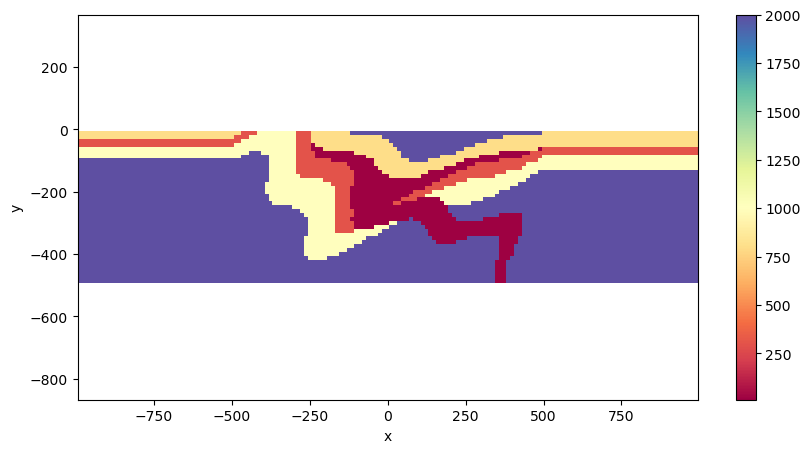

(13651,) 6201


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
dd = meshCore.plot_image(physy_model[actcore], ax=ax, pcolor_opts={'cmap':'Spectral'})
plt.colorbar(dd[0])
plt.axis('equal')
plt.show()
print(interpolated_values.shape, meshCore.nC)

# np.save('complex_model.npy', physy_model)

In [ ]:
xmin, xmax = -750., 750.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in [50]:

    print(f'adding dipole size: {dipole}')
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=30,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=30,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    np.log(physy_model[actcore]),
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())

adding dipole size: 50


/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


0.3214913041811542
643.5097681703803


0.3214913041811542
643.5097681703803
1.5198634191705784 0.000531095671679305
5.518911208002285


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

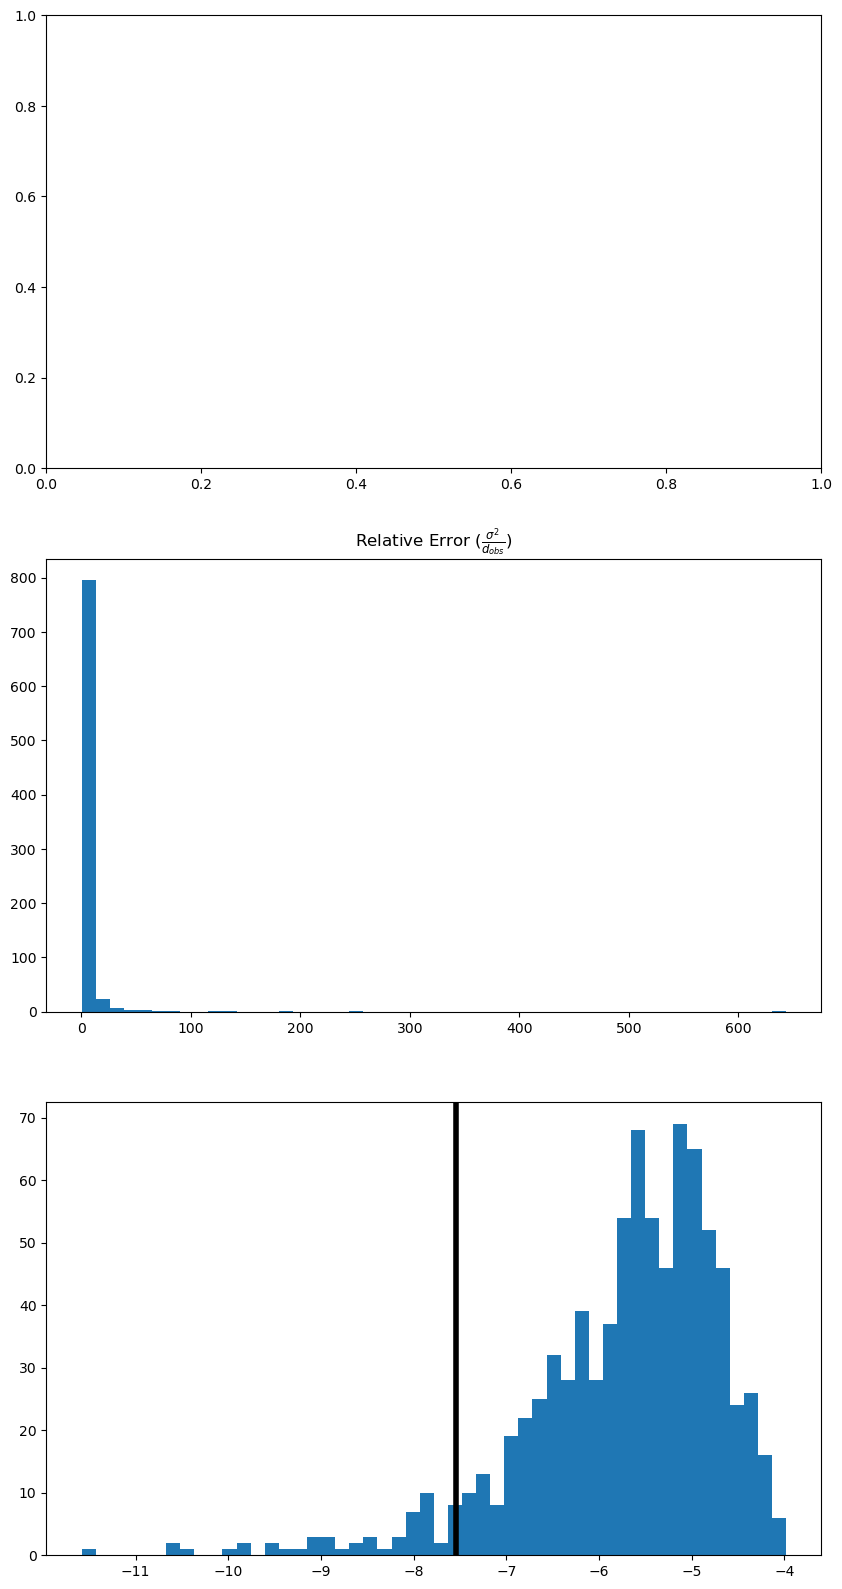

In [ ]:
fig,ax = plt.subplots(3, 1,figsize=(10,20))
relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list), np.quantile(np.abs(dc_data.dobs), 0.06))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.06)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

In [21]:
import numpy as np

class SegmentationNorm:
    def __init__(self, Z, c):
        """
        Initialize the class with matrix Z and vector c.
        
        Parameters:
        Z (numpy.ndarray): A 2D array with shape (N_c, N_x * N_z).
        c (numpy.ndarray): A 1D array with length N_c.
        """
        self.Z = Z
        self.c = c
        self.N_c = Z.shape[0]
        self.N_xz = Z.shape[1]
    
    def __call__(self, m):
        """
        Evaluate the function phi_{m,Z}.
        
        Parameters:
        m (numpy.ndarray): A 1D array with length N_x * N_z.
        
        Returns:
        float: The value of the function phi_{m,Z}.
        """
        phi = 0.0
        for j in range(self.N_c):
            for i in range(self.N_xz):
                phi += self.Z[j, i] * (m[i] - self.c[j])**2
        return phi
    
    def deriv(self, m):
        """
        Evaluate the gradient of phi_{m,Z} with respect to m.
        
        Parameters:
        m (numpy.ndarray): A 1D array with length N_x * N_z.
        
        Returns:
        numpy.ndarray: The gradient of phi_{m,Z} with respect to m.
        """
        grad = np.zeros_like(m)
        for i in range(self.N_xz):
            grad[i] = 2 * np.sum(self.Z[:, i] * (m[i] - self.c))
        return grad
    
    def deriv2(self):
        """
        Evaluate the Hessian of phi_{m,Z} with respect to m.
        
        Returns:
        numpy.ndarray: The Hessian matrix of phi_{m,Z}.
        """
        H = np.zeros((self.N_xz, self.N_xz))
        for i in range(self.N_xz):
            H[i, i] = 2 * np.sum(self.Z[:, i])
        return H

# Example usage

# Z = np.array([[1, 2, 3, 5], [3, 4, 7, 6]])
Z = np.zeros((2, actcore.sum())) + 0.1
c = np.array([np.log(1/500), np.log(1/10)])
m = np.load(f'admm_iter/model_{14}.npy')

phi_mz = SegmentationNorm(Z, c)

# Evaluate the function
phi_value = phi_mz(m)
print("Function value:", phi_value)

# Evaluate the gradient
gradient_value = phi_mz.deriv(m)
print("Gradient value:", gradient_value)

# Evaluate the Hessian
hessian_value = phi_mz.deriv2()
print("Hessian value:\n", hessian_value)


Function value: 4371.3900278371575
Gradient value: [-0.82875266 -0.8278261  -0.82656091 ... -0.85533322 -0.85533322
 -0.71452795]
Hessian value:
 [[0.4 0.  0.  ... 0.  0.  0. ]
 [0.  0.4 0.  ... 0.  0.  0. ]
 [0.  0.  0.4 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.4 0.  0. ]
 [0.  0.  0.  ... 0.  0.4 0. ]
 [0.  0.  0.  ... 0.  0.  0.4]]


In [20]:
phi_mz.N_xz

4558

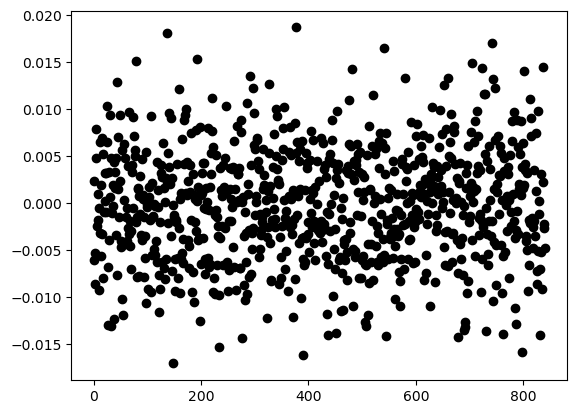

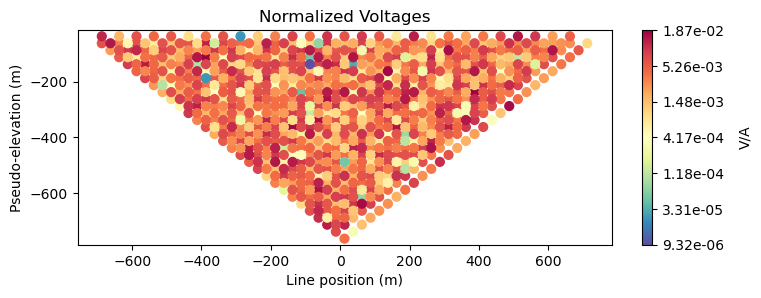

In [ ]:
plt.plot(dc_data.dobs, 'ok')

from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=dc_data.dobs,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": 'Spectral_r'},
)
ax1.set_title("Normalized Voltages")
plt.show()